# Drop-out experiments

# Imports and Load Individual Models

In [1]:
# basic
import os
import pandas as pd
import re
import numpy as np
import copy

# see functions.py for a collection of self-written functions for analysing and visualising my models
from functions import *

# cobra & micom
from cobra.io import read_sbml_model, write_sbml_model
from cobra.flux_analysis import pfba, flux_variability_analysis
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from micom import Community
from micom.problems import cooperative_tradeoff
from micom import load_pickle

# plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
# Load SBML Models - individuals
models_path = "../Models/12_gap_filled/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


In [3]:
# Load SBML Models - Gap Filled but NO Sucrose Fixes - individuals
models_path = "../Models/12_1_noSucroseFix/"
models_noS = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3]+"_noS")
    models_noS[name] = model

models_noS = {key: models_noS[key] for key in sorted(models_noS.keys())}  # sorts the dictionary alphabetically
AA1_noS, AA2_noS, AA3_noS, AA4_noS, AA5_noS, AA6_noS, AA7_noS = [models_noS[f"AA{i}_noS"] for i in range(1, 8)]

# Functions

In [3]:
def e_to_m(medium):
    if isinstance(medium, dict):
        # Convert reaction IDs ending in '_e' to '_m'
        medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium.items()}
        return medium_dict

    elif isinstance(medium, pd.DataFrame):
        # Convert DataFrame to a dict with converted reaction IDs
        medium_dict = {rxn.removesuffix('_e') + '_m' if rxn.endswith('_e') else rxn: bound for rxn, bound in zip(medium["reaction"], medium["bound"])}
        return medium_dict

    else:
        return "Medium is wrong data type"


# Medium

In [4]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9_rxn = list(m9["reaction"])

In [4]:
medium_combined_naveed = pd.read_csv("../Datasets/Medium/medium_combined_Naveed_M9.csv", sep=";", quotechar='"')
medium_combined_krumbach= pd.read_csv("../Datasets/Medium/medium_combined_Krumbach_M9.csv", sep=";", quotechar='"')

In [5]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

In [6]:
ecoplate_short = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon_shortened.csv", sep=";", quotechar='"')
ecoplate_rxns_short = [safe_parse(x) for x in ecoplate_short["reaction"]]

# Create C7 Community Model with MICOM

In [7]:
taxonomy = pd.read_csv("../Datasets/community_model_gap_filled.csv", sep=";")
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

In [10]:
taxonomy_noS = pd.read_csv("../Datasets/community_model_noSucrose.csv", sep=";")
syncom_half = Community(taxonomy_noS.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7_half", solver="cplex")

for rxn in syncom_half.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

# Create Drop-out Communities
From our C7 community we want to exclude one bacterium at a time making it a C6 community

In [9]:
# Load Models - Gap Filled but NO Sucrose Fixes - drop outs
models_path = "../Models/12_1_noSucroseFix/Drop_outs_pickle"
drops_noS = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".pickle")):
    model = load_pickle(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:2]+"_noS")
    drops_noS[name] = model

drops_noS = {key: drops_noS[key] for key in sorted(drops_noS.keys())}  # sorts the dictionary alphabetically
S1_noS, S2_noS, S3_noS, S4_noS, S5_noS, S6_noS, S7_noS = [drops_noS[f"S{i}_noS"] for i in range(1, 8)]

In [14]:
# Create Models from Scratch
syncoms_half = {}

for i in range(len(taxonomy_noS)):
    cut_tax = taxonomy_noS.drop(index=taxonomy_noS.index[i])
    name = f"syncom_drop{i+1}_2"

    com = Community(
        cut_tax.iloc[:, :-1],
        name="synthetic six member bacterial community",
        id=name,
        solver="cplex")

    # Set EX reaction bounds for this syncom
    for rxn in com.reactions.query("^EX_"):
        rxn.lower_bound = -1000  # make exchange freely available

    syncoms_half[name] = com

S1_2, S2_2, S3_2, S4_2, S5_2, S6_2, S7_2 = [syncoms_half[f"syncom_drop{i+1}_2"] for i in range(7)]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [9]:
# Load Models - Gap Filled - drop outs
models_path = "../Models/12_gap_filled/Drop_outs_pickle"
drops = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".pickle")):
    model = load_pickle(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:2])
    drops[name] = model

drops = {key: drops[key] for key in sorted(drops.keys())}  # sorts the dictionary alphabetically
S1, S2, S3, S4, S5, S6, S7 = [drops[f"S{i}"] for i in range(1, 8)]

In [23]:
# Create Models from Scratch (i.e. from their individual models, that takes some time, that is why I saved them also as pickles)
syncoms = {}

for i in range(len(taxonomy)):
    cut_tax = taxonomy.drop(index=taxonomy.index[i])
    name = f"syncom_drop{i+1}"

    com = Community(
        cut_tax.iloc[:, :-1],
        name="synthetic six member bacterial community",
        id=name,
        solver="cplex")

    # Set EX reaction bounds for this syncom
    for rxn in com.reactions.query("^EX_"):
        rxn.lower_bound = -1000  # make exchange freely available

    syncoms[name] = com

S1, S2, S3, S4, S5, S6, S7 = [syncoms[f"syncom_drop{i+1}"] for i in range(7)]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [10]:
all_models = {**drops, 'C7_Community': syncom}

In [11]:
all_models_half = {**drops_noS, 'C7_Community': syncom_half}

ATTENTION: "normal" saving with write_sbml_model doesnt work for MICOM Community model \
I need to save them as pickles \
see: https://resendislab.github.io/micom/community.html#Saving-and-loading-communities

In [16]:
# save all drop-out models as file
#for i, model in enumerate(syncoms.values(), start=1):
 #   path = f"/home/lisa/Dokumente/Programmierung/Models/12_gap_filled/Drop_outs/S{i}.xml"
  #  write_sbml_model(model, path)

In [21]:
# save all drop-out models as pickles
for i, model in enumerate(syncoms_half.values(), start=1):
    path = f"../Models/12_1_noSucroseFix/Drop_outs_pickle/S{i}_noS.pickle"
    model.to_pickle(path)

In [24]:
# save all drop-out models as pickles
for i, model in enumerate(syncoms.values(), start=1):
    path = f"../Models/12_gap_filled/Drop_outs_pickle/S{i}.pickle"
    model.to_pickle(path)

# Growth for all drop-out syncoms

In [12]:
test_medium(syncom, medium_combined_krumbach)

model
AA1    17.872157
AA2    18.809741
AA3    14.676299
AA4    14.640428
AA5    15.018397
AA6    14.938410
AA7    15.187845
Name: Growth, dtype: float64

In [13]:
test_medium(syncom, medium_combined_naveed)

model
AA1    12.782515
AA2    14.596887
AA3     0.000170
AA4    33.077317
AA5    19.563136
AA6    17.982364
AA7    21.346332
Name: Growth, dtype: float64

In [17]:
for model in all_models.values():
    print(test_medium(model, medium_combined_krumbach))

model
AA2    20.995824
AA3    12.912899
AA4    14.621185
AA5    13.380431
AA6    14.681867
AA7    15.110819
Name: Growth, dtype: float64
model
AA1    17.339245
AA3    14.877365
AA4    15.183806
AA5    15.323560
AA6    15.301576
AA7    15.400286
Name: Growth, dtype: float64
model
AA1    17.362514
AA2    18.763093
AA4    17.203504
AA5    17.367572
AA6    16.833443
AA7    17.439878
Name: Growth, dtype: float64
model
AA1    19.000933
AA2    18.948917
AA3    10.071253
AA5    17.934955
AA6    18.290222
AA7     8.142352
Name: Growth, dtype: float64
model
AA1    17.281426
AA2    17.784580
AA3    12.861368
AA4    15.079412
AA6    15.261536
AA7    15.452583
Name: Growth, dtype: float64
model
AA1    17.807310
AA2    17.618129
AA3    13.798409
AA4    14.553767
AA5    14.066843
AA7    15.083033
Name: Growth, dtype: float64
model
AA1    17.369746
AA2    17.275897
AA3    14.340583
AA4    14.408890
AA5    14.665969
AA6    14.914126
Name: Growth, dtype: float64
model
AA1    17.873104
AA2    18.810325
A

In [16]:
def custom_format(x):
    if round(x, 2) == 0:
        return "0"  # no decimals for 0
    else:
        return f"{x:.2f}"  # 2 decimals otherwise

def heatmap_growth_dropouts(models, medium, medium_name, save_path=None):
    growth_data = {}

    for name, syncom in models.items():
        _, growth = community_pfba(syncom, medium)
        if growth is not None:
            growth_data[name] = growth

    growth_df = pd.DataFrame(growth_data).transpose()

    epsilon = 1e-6
    growth_df = growth_df.applymap(lambda x: 0 if abs(x) < epsilon else x)

    # --- Rename strains (columns) ---
    strain_map = {
        "AA1": "Sma",
        "AA2": "Bpi",
        "AA3": "Cpu",
        "AA4": "Elu",
        "AA5": "Cin",
        "AA6": "Hro",
        "AA7": "Ppu"
    }
    growth_df = growth_df.rename(columns=strain_map)

    # --- Rename communities (rows) ---
    community_map = {
        "C7_Community": "C7",
        "S1": "C6-Sma",
        "S2": "C6-Bpi",
        "S3": "C6-Cpu",
        "S4": "C6-Elu",
        "S5": "C6-Cin",
        "S6": "C6-Hro",
        "S7": "C6-Ppu"
    }
    growth_df = growth_df.rename(index=community_map)
    #return growth_df

    # Desired plotting order
    strain_order = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu"]
    community_order = ["C7", "C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu"]


    plt.figure(figsize=(10, 6))

    growth_df = growth_df.apply(pd.to_numeric, errors='coerce')
    annot_str = growth_df.applymap(custom_format)
    annot_data = annot_str.loc[community_order, strain_order].T

    ax = sns.heatmap(
        growth_df.loc[community_order, strain_order].T,
        fmt="",
        annot=annot_data,
        cmap="Reds",
        cbar_kws={'label': 'growth rate\n[mmol/(gDW h)]'}
    )

    ax.set_xticklabels(community_order, rotation=45, ha="right")
    ax.set_yticklabels(strain_order, rotation=0)

    # Make NaN background white
    ax.set_facecolor("white")

    plt.title(f"Growth rates per strain across community model variants on {medium_name} medium")
    plt.xlabel("Community variant")
    plt.ylabel("Strains")
    plt.tight_layout()

    if save_path is not None:
        file_name = f"drop_outs_growth_{medium_name}.svg"
        plt.savefig(f"../Figures/MA_Results/{file_name}", format="svg", bbox_inches="tight")
    plt.show()

    return growth_df


In [39]:
del_suc = ["EX_sucr_e__AA1", "EX_sucr_e__AA3","EX_sucr_e__AA5", "EX_sucr_e__AA6"]
for rxn_id in del_suc:
    if rxn_id in S7_2.reactions:
        S7_2.reactions.get_by_id(rxn_id).bounds = (0, 1000)

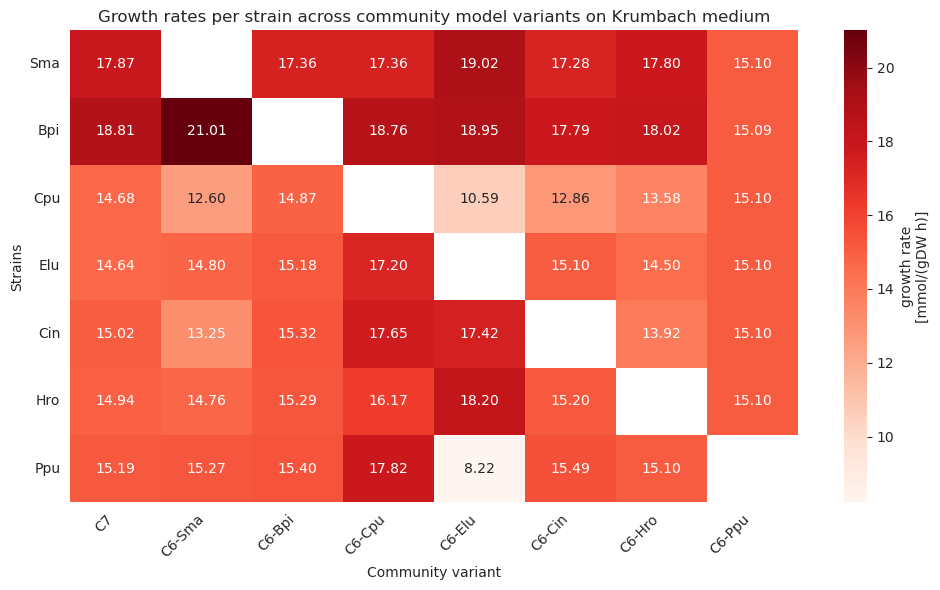

In [17]:
growth_krumbach_df = heatmap_growth_dropouts(all_models, medium_combined_krumbach, "Krumbach", save_path=False)

In [18]:
growth_krumbach_df["row_sum"] = growth_krumbach_df.sum(axis=1)

In [19]:
growth_krumbach_df["row_sum_average"] = growth_krumbach_df.mean(axis=1)

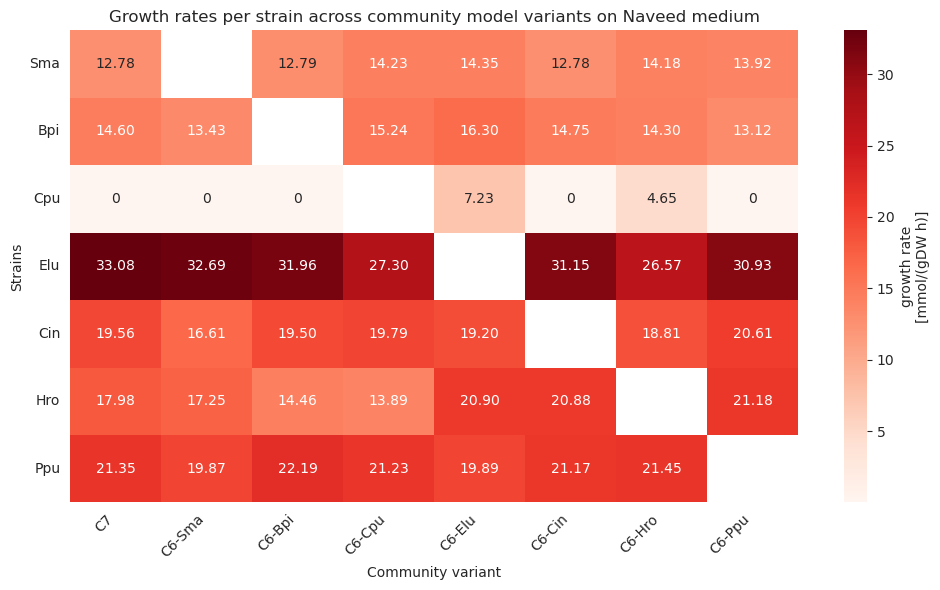

In [20]:
growth_naveed_df = heatmap_growth_dropouts(all_models, medium_combined_naveed, "Naveed", save_path=False)

In [21]:
growth_naveed_df["row_sum"] = growth_naveed_df.sum(axis=1)
growth_naveed_df["row_sum_average"] = growth_naveed_df.mean(axis=1)

In [16]:
s7_fluxes = convert_cooptradeoff_into_fluxes(S7, medium_combined_krumbach)

In [64]:
# pFBA in comparison to coop. tradeoff
for model in drops_noS.values():
    with model:
        change_medium(model, medium_combined_krumbach)
        fluxes = pfba(model).fluxes
        print(model.id)
        print(fluxes[fluxes.index.str.contains("Growth")])

syncom_drop1_2
Growth__AA2    17.900084
Growth__AA3     0.310094
Growth__AA4    24.001689
Growth__AA5    16.544492
Growth__AA6    17.085642
Growth__AA7    15.436067
Name: fluxes, dtype: float64
syncom_drop2_2
Growth__AA1    17.302014
Growth__AA3    12.887016
Growth__AA4    13.439732
Growth__AA5    15.781133
Growth__AA6    13.309059
Growth__AA7    20.702751
Name: fluxes, dtype: float64
syncom_drop3_2
Growth__AA1    17.319572
Growth__AA2    18.740756
Growth__AA4    17.192796
Growth__AA5    20.493839
Growth__AA6    11.772445
Growth__AA7    19.446233
Name: fluxes, dtype: float64
syncom_drop4_2
Growth__AA1    18.936368
Growth__AA2    19.016091
Growth__AA3     5.252942
Growth__AA5    17.960786
Growth__AA6    22.979287
Growth__AA7     8.237776
Name: fluxes, dtype: float64
syncom_drop5_2
Growth__AA1    17.308230
Growth__AA2    18.783916
Growth__AA3    12.030801
Growth__AA4    14.882702
Growth__AA6    13.213006
Growth__AA7    17.497680
Name: fluxes, dtype: float64
syncom_drop6_2
Growth__AA1    

In [49]:
with S7:
    change_medium(S7, medium_combined_krumbach)
    fluxes = pfba(S7).fluxes

In [53]:
fluxes[fluxes.index.str.contains("Growth")].sum()

90.57457529871557

In [50]:
with S7:
    change_medium(S7, medium_combined_krumbach)
    fluxes2 = S7.cooperative_tradeoff(pfba=True, fluxes=True).fluxes.T

In [59]:
fluxes2[fluxes2.index.str.contains("Growth")].T

reaction,Growth
compartment,
AA1,15.097689
AA2,15.086133
AA3,15.097689
AA4,15.097689
AA5,15.097689
AA6,15.097689
medium,NaN


In [57]:
fluxes2[fluxes2.index.str.contains("Growth")].sum(axis=1)

reaction
Growth    90.574576
dtype: float64

In [47]:
with S7_2:
    change_medium(S7_2, medium_combined_krumbach)
    s7_pfba_withS = pfba(S7_2).fluxes

# PCA & Clustering

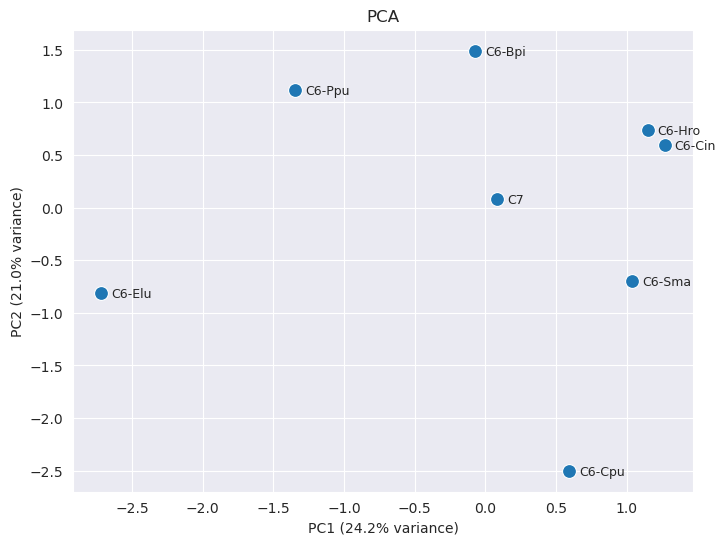

In [39]:
pca(growth_krumbach_df, "../Figures/MA_Results/DropOuts_PCA_Krumbach.svg")

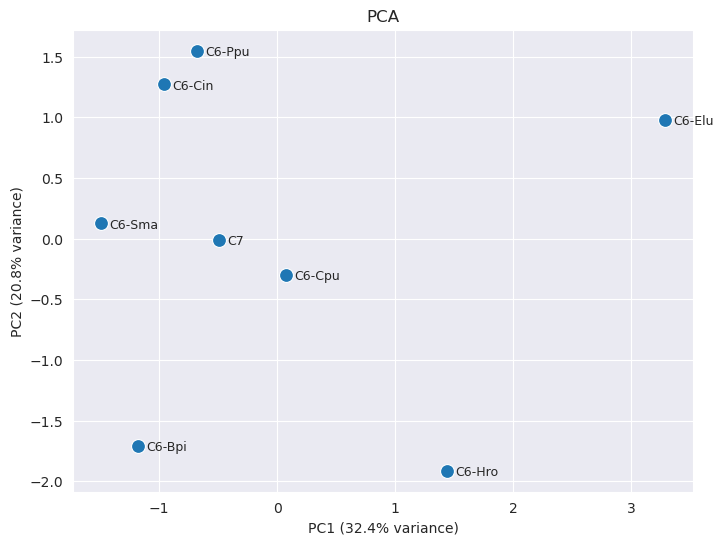

In [43]:
pca(growth_naveed_df, "../Figures/MA_Results/DropOuts_PCA_Naveed.svg")

Dimension reduction on all fluxes, not just growth rates

In [60]:
flux_tables = {}

for model_name, model in all_models.items():
    flux_series = get_pfba_fluxes(model, medium_combined_krumbach)  # Krumbach
    flux_tables[model_name] = flux_series

# Combine into one dataframe
big_df = pd.concat(flux_tables, axis=1)

# Replace missing reactions with zero
big_df = big_df.fillna(0)

# set model names as columns (instead of MultiIndex)
big_df.columns = big_df.columns.get_level_values(0)

In [62]:
community_map = { "C7_Community": "C7", "S1": "C6-Sma", "S2": "C6-Bpi", "S3": "C6-Cpu", "S4": "C6-Elu", "S5": "C6-Cin", "S6": "C6-Hro", "S7": "C6-Ppu" }
big_df = big_df.rename(columns=community_map)

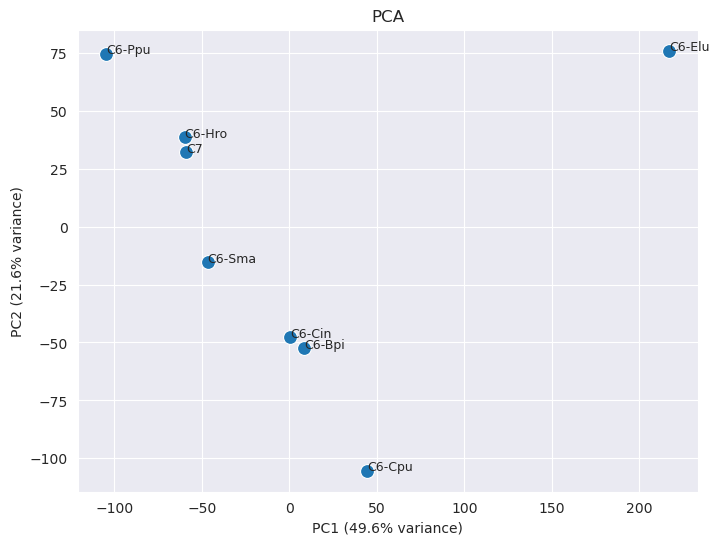

In [63]:
pca(big_df.T, "../Figures/MA_Results/DropOuts_PCA_Krumbach_all.svg") # krumbach

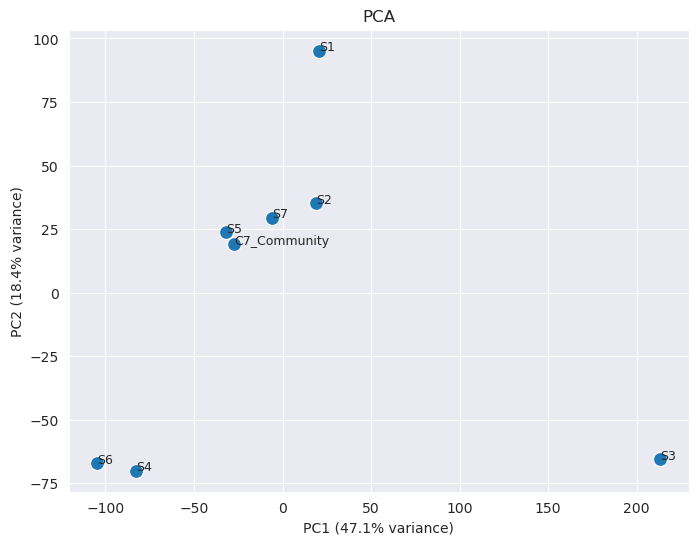

In [24]:
flux_tables = {}

for model_name, model in all_models.items():
    flux_series = get_pfba_fluxes(model, medium_combined_naveed)  # Naveed
    flux_tables[model_name] = flux_series

# Combine into one dataframe
big_df = pd.concat(flux_tables, axis=1)

# Replace missing reactions with zero
big_df = big_df.fillna(0)

# set model names as columns (instead of MultiIndex)
big_df.columns = big_df.columns.get_level_values(0)

big_df = big_df.rename(columns=community_map)

# PCA
pca(big_df.T)

compare both media but only exchange reactions

In [87]:
# Define media
media_dict = {
    "Krumbach": medium_combined_krumbach,
    "Naveed": medium_combined_naveed
}

# Prepare an empty dict to store fluxes
flux_tables = {}

# Loop over models and media
for model_name, model in all_models.items():
    for medium_name, medium in media_dict.items():
        flux_series = get_pfba_fluxes(model, medium)

        # filter series to only have Exchange reactions and not all reactions
        # because we have a community, this includes exchanges between the models and the shared compartment and the uptake7secretion of the environment with the whole community model
        flux_series = flux_series[flux_series.index.str.startswith("EX")]

        # Store with a combined key (model + medium)
        flux_tables[f"{model_name}_{medium_name}"] = flux_series

In [88]:
# Combine into one dataframe
big_df = pd.concat(flux_tables, axis=1).fillna(0)

# Optional: flatten columns if MultiIndex
if isinstance(big_df.columns, pd.MultiIndex):
    big_df.columns = big_df.columns.get_level_values(0)

# Rename models using community_map
new_cols = []
for col in big_df.columns:
    model, medium = col.rsplit("_", 1)   # split only at the last underscore
    model_name = community_map.get(model, model)
    new_cols.append(f"{model_name}_{medium}")

big_df.columns = [community_map.get(col.rsplit("_", 1)[0], col.rsplit("_", 1)[0])
                  for col in big_df.columns]

# Create a medium mapping for coloring
colooors = sns.color_palette("Set2")
medium_colors = {"Krumbach": colooors[1], "Naveed": colooors[0]}

# Assign colors based on medium in original flux_tables keys
point_colors = [
    medium_colors[col.rsplit("_", 1)[1]]  # last part is medium
    for col in flux_tables.keys()
]


In [89]:
def pca2(df, save_path=None, colors=None, color_legend=None, title="PCA"):
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import matplotlib.patches as mpatches

    # Standardise the data
    scaler = StandardScaler()
    growth_df_filled = df.fillna(0)
    scaled_growth = scaler.fit_transform(growth_df_filled)

    # Perform PCA
    pca_model = PCA(n_components=2)
    pca_result = pca_model.fit_transform(scaled_growth)

    # Create df for PCA result
    pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=df.index)

    plt.figure(figsize=(8, 6))

    # Plot points with colors
    if colors is not None:
        if isinstance(colors, dict):
            point_colors = [colors.get(i, "gray") for i in df.index]
        else:
            point_colors = colors
        plt.scatter(pca_df["PC1"], pca_df["PC2"], c=point_colors, s=100)
    else:
        plt.scatter(pca_df["PC1"], pca_df["PC2"], s=100, color="blue")

    # Annotate points
    for name, row in pca_df.iterrows():
        plt.text(row["PC1"] + 0.07, row["PC2"] - 0.04, name, fontsize=9)

    # Add variance explained info
    pc1_var = pca_model.explained_variance_ratio_[0] * 100
    pc2_var = pca_model.explained_variance_ratio_[1] * 100
    plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
    plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")
    plt.title(title)
    plt.grid(True)

    # Add legend if provided
    if color_legend is not None:
        handles = [mpatches.Patch(color=color, label=label) for label, color in color_legend.items()]
        plt.legend(handles=handles, title="Medium")

    if save_path is not None:
        plt.savefig(save_path, format="svg", bbox_inches="tight")
    plt.show()


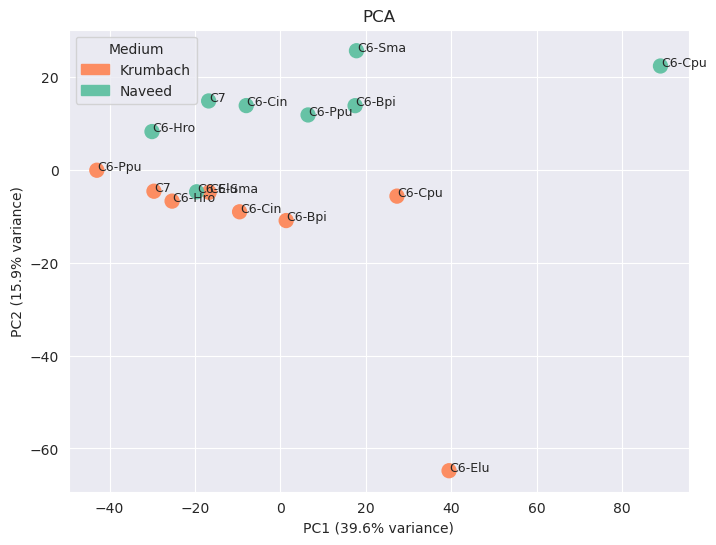

In [92]:
pca2(big_df.T, colors=point_colors, color_legend=medium_colors, save_path="../Figures/MA_Results/DropOuts_PCA_bothMedia_ex.svg")

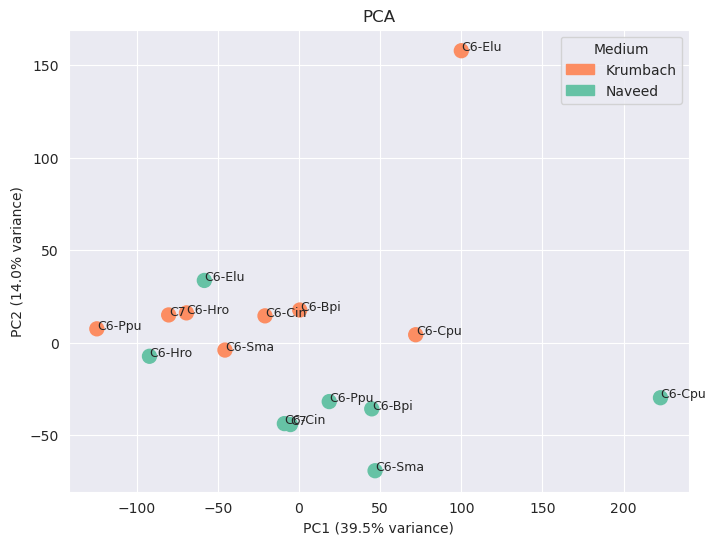

In [82]:
pca2(big_df.T, colors=point_colors, color_legend=medium_colors, save_path="../Figures/MA_Results/DropOuts_PCA_bothMedia_all.svg")

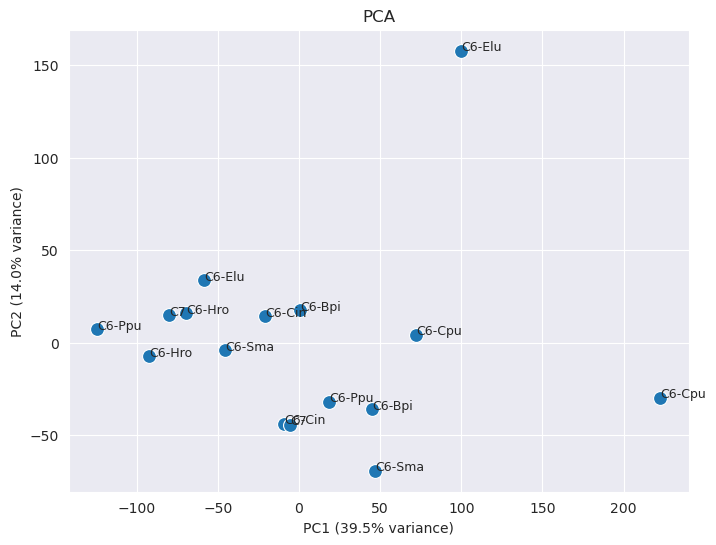

TypeError: 'NoneType' object is not subscriptable

<Figure size 700x700 with 0 Axes>

In [69]:
# Run PCA (transpose so models are rows)
coords = pca(big_df.T)

# Plot with color according to medium
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
for i, col in enumerate(big_df.columns):
    plt.scatter(coords[i,0], coords[i,1], color=point_colors[i], s=100)
    plt.text(coords[i,0]+0.01, coords[i,1]+0.01, col, fontsize=10)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of models under two media")
plt.grid(True)
plt.tight_layout()
plt.show()

Similarity on only the existence of reactions

In [11]:
# 1) collect all unique reactions
all_rxns = set()
for model in all_models.values():
    all_rxns.update([rxn.id for rxn in model.reactions])

all_rxns = sorted(all_rxns)  # consistent ordering

# 2) fill matrix: rows=reactions, cols=models, values=1/0
binary_df = pd.DataFrame(0, index=all_rxns, columns=all_models.keys())

for model_name, model in all_models.items():
    model_rxns = [rxn.id for rxn in model.reactions]
    binary_df.loc[model_rxns, model_name] = 1


In [29]:
community_map = { "C7_Community": "C7", "S1": "C6-Sma", "S2": "C6-Bpi", "S3": "C6-Cpu", "S4": "C6-Elu", "S5": "C6-Cin", "S6": "C6-Hro", "S7": "C6-Ppu" }
binary_df = binary_df.rename(columns=community_map)

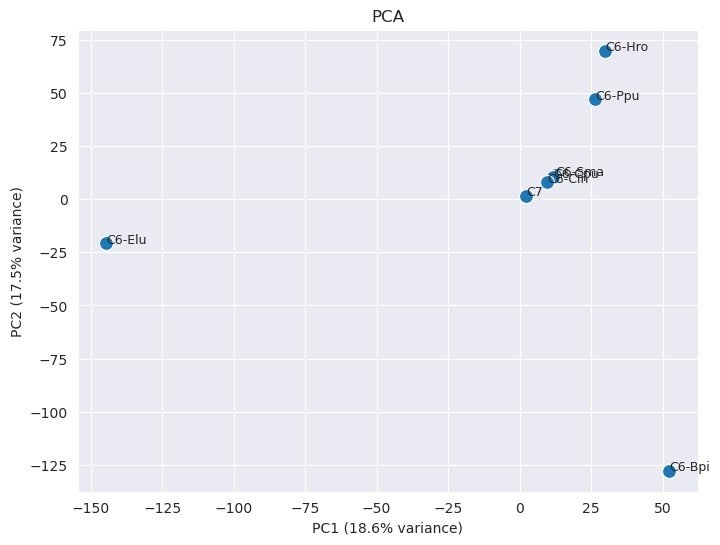

In [32]:
pca(binary_df.T) # in theory PCA is not so good for binary/discrete data

In [18]:
from sklearn.metrics import pairwise_distances

# 1) convert to boolean and transpose once
binary_bool = binary_df.T.astype(bool)          # models × reactions

# 2) compute Jaccard distance
jaccard_dist = pairwise_distances(binary_bool.values, metric="jaccard")

# 3) convert to similarity matrix
jaccard_sim = 1 - jaccard_dist
jaccard_sim_df = pd.DataFrame(jaccard_sim,
                              index=binary_df.columns,
                              columns=binary_df.columns)

jaccard_sim_df


,S1,S2,S3,S4,S5,S6,S7,C7_Community
S1,1.000000,0.720651,0.746344,0.710769,0.752612,0.726071,0.727766,0.872042
S2,0.720651,1.000000,0.722909,0.687334,0.729177,0.702637,0.704331,0.848608
S3,0.746344,0.722909,1.000000,0.713027,0.754870,0.728330,0.730024,0.874301
S4,0.710769,0.687334,0.713027,1.000000,0.719295,0.692755,0.694449,0.838726
S5,0.752612,0.729177,0.754870,0.719295,1.000000,0.734598,0.736292,0.880569
S6,0.726071,0.702637,0.728330,0.692755,0.734598,1.000000,0.709752,0.854029
S7,0.727766,0.704331,0.730024,0.694449,0.736292,0.709752,1.000000,0.855723
C7_Community,0.872042,0.848608,0.874301,0.838726,0.880569,0.854029,0.855723,1.000000


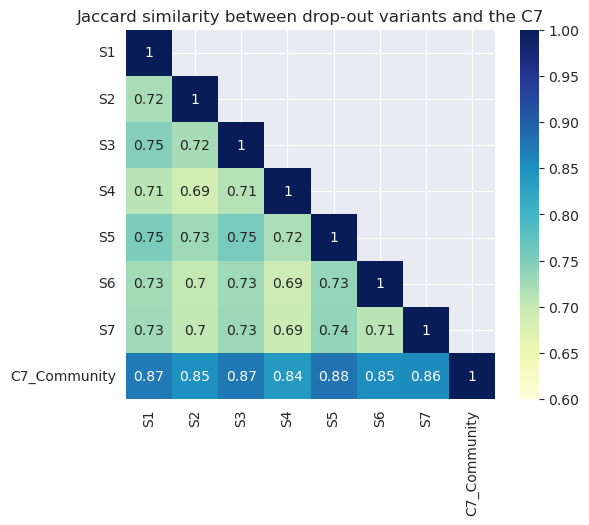

In [59]:
jaccard_df = pd.DataFrame(
    jaccard_sim,
    index=binary_bool.index,
    columns=binary_bool.index
)

# jaccard_df is your square similarity matrix
mask = np.triu(np.ones_like(jaccard_df, dtype=bool), k=1)

sns.heatmap(
    jaccard_df,
    mask=mask,
    annot=True,
    cmap="YlGnBu",
    square=True,
    cbar=True,
    vmin=0.6, vmax=1
)

plt.title("Jaccard similarity between drop-out variants and the C7")
plt.savefig("../Figures/MA_Results/DropOuts_Jaccard.svg", format="svg")
plt.show()


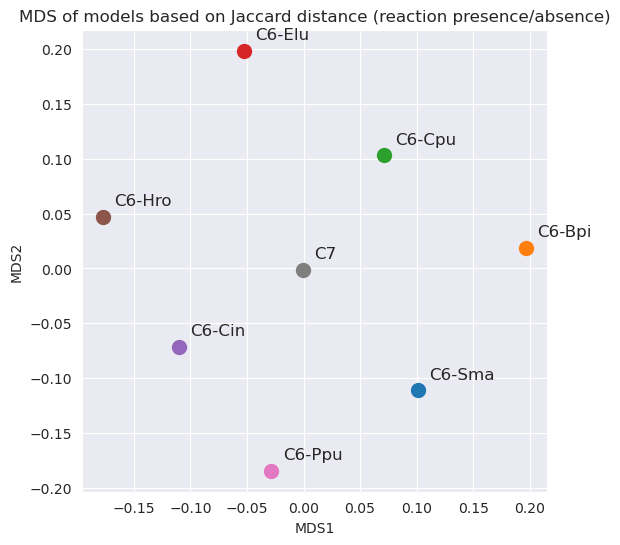

In [33]:
from sklearn.manifold import MDS
# MDS doesnt really work lol

# jaccard_dist is already your distance matrix (from pairwise_distances)
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
coords = mds.fit_transform(jaccard_dist)  # shape: (n_models, 2)

# Plotting
plt.figure(figsize=(6,6))
for i, model in enumerate(binary_df.columns):
    plt.scatter(coords[i,0], coords[i,1], s=100)
    plt.text(coords[i,0]+0.01, coords[i,1]+0.01, model, fontsize=12)

plt.title("MDS of models based on Jaccard distance (reaction presence/absence)")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.grid(True)
plt.show()

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:258: RuntimeWarning: The result contains negative eigenvalues that are large in magnitude, which may suggest result inaccuracy. See Notes for details. The negative-most eigenvalue is -0.012189479263315907 whereas the largest positive one is 0.05013813769086461.
  warn(


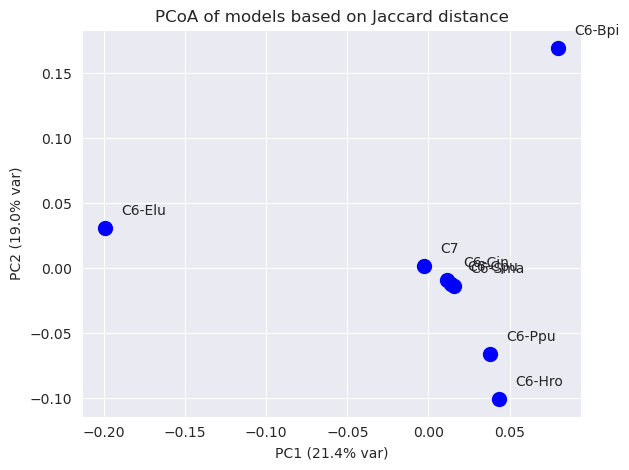

In [58]:
import pandas as pd
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
# https://www.geeksforgeeks.org/machine-learning/principal-coordinates-analysis-pcoa-a-comprehensive-guide/
# https://files.cercomp.ufg.br/weby/up/417/o/Numerical_Ecology.pdf?1458165083

# jaccard_dist is distance matrix (distance not similarity)
jaccard_dist_df = pd.DataFrame(jaccard_dist, index=binary_df.columns, columns=binary_df.columns)

# Run PCoA
pcoa_results = pcoa(jaccard_dist_df)

# Get the coordinates for the first two axes
coords = pcoa_results.samples.iloc[:, 0:2]

group_colors = {
    "C6-Sma": "blue",
    "C6-Bpi": "green",
    "C6-Cpu": "purple",
    "C6-Elu": "orange",
    "C6-Cin": "brown",
    "C6-Hro": "pink",
    "C6-Ppu": "cyan",
    "C7": "red"
}
coords_df = coords.copy()
coords_df.index = binary_df.columns
coords_df.index = [community_map.get(x, x) for x in binary_df.columns]


# Plot
for model in coords_df.index:
    plt.scatter(
        coords_df.loc[model, coords_df.columns[0]],
        coords_df.loc[model, coords_df.columns[1]],
        s=100,
        color="blue",
        label=model
    )
    # Optional: add text labels next to points
    plt.text(
        coords_df.loc[model, coords_df.columns[0]] + 0.01,
        coords_df.loc[model, coords_df.columns[1]] + 0.01,
        model,
        fontsize=10
    )


# Get proportion of variance explained
explained_var = pcoa_results.proportion_explained

plt.xlabel(f"{coords_df.columns[0]} ({explained_var[0]*100:.1f}% var)")
plt.ylabel(f"{coords_df.columns[1]} ({explained_var[1]*100:.1f}% var)")
plt.title("PCoA of models based on Jaccard distance")
plt.grid(True)
plt.tight_layout()
#plt.savefig("../Figures/MA_Results/DropOuts_PCoA_reactions.svg", format="svg")
plt.show()

# Growth on Single Carbon Sources

In [11]:
carbon_sources = ["EX_glc__D_e", "EX_sucr_e", "EX_xyl__D_e", ["EX_mal__L_e", "EX_mal__L_e"], "EX_pyr_e", "EX_succ_e", ["EX_ala__L_e", "EX_ala__L_e"], "EX_glu__L_e", "EX_gly_e"]

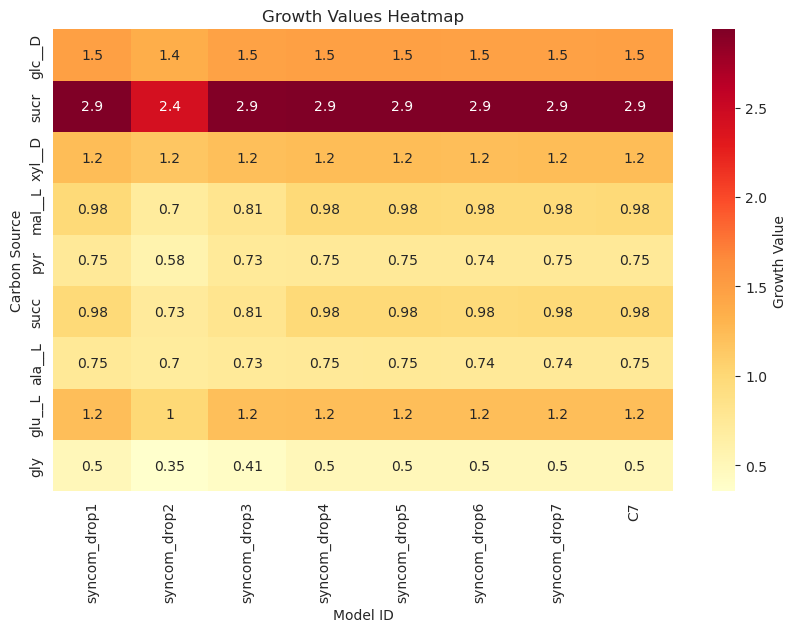

In [12]:
carbon_df = create_medium(carbon_sources, m9_rxn, all_models, 10, carbon_only=True)

# Substrate Utilisation (BIOLOG Ecoplate)

def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):

In [13]:
metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "4-Hydroxy benzoic acid", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]

[10/27/25 13:43:36] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=397635;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=684027;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/27/25 13:43:38] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=201259;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=171204;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/27/25 13:43:40] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=762442;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=881450;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/27/25 13:43:42] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=416039;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=365469;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/27/25 13:43:44] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=889413;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=44039;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/27/25 13:43:46] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=207593;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=876889;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/27/25 13:43:48] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=990413;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=74367;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/27/25 13:43:50] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=536699;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=620129;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

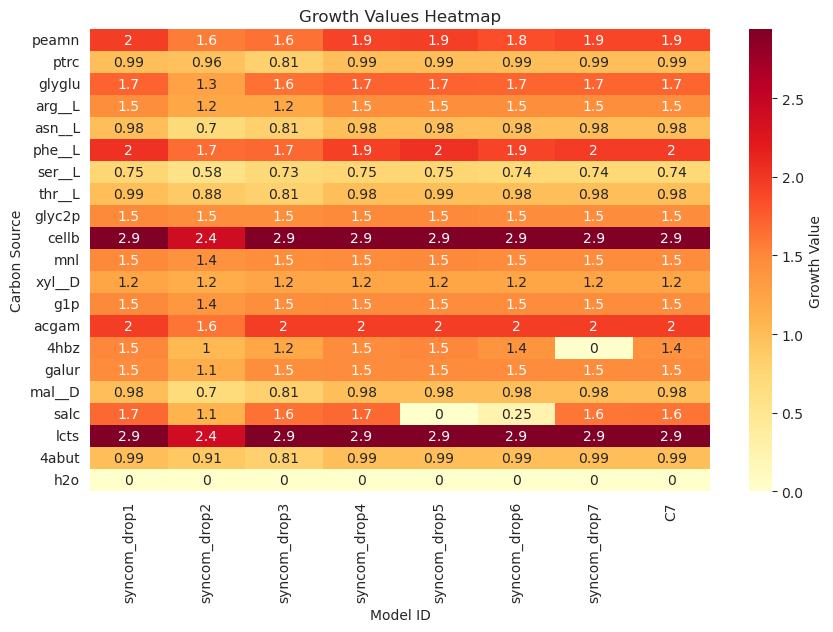

In [14]:
ecoplate_df = create_medium(ecoplate_rxns, m9_rxn, all_models, 10, carbon_only=True, average="yes")
# takes around 9min

In [29]:
# Ensure numeric
ecoplate_df = ecoplate_df.apply(pd.to_numeric, errors='coerce')

def custom_format(x):
    if round(x, 2) == 0:
        return "0"  # no decimals for 0
    else:
        return f"{x:.2f}"  # 2 decimals otherwise

annot_str = ecoplate_df.applymap(custom_format)

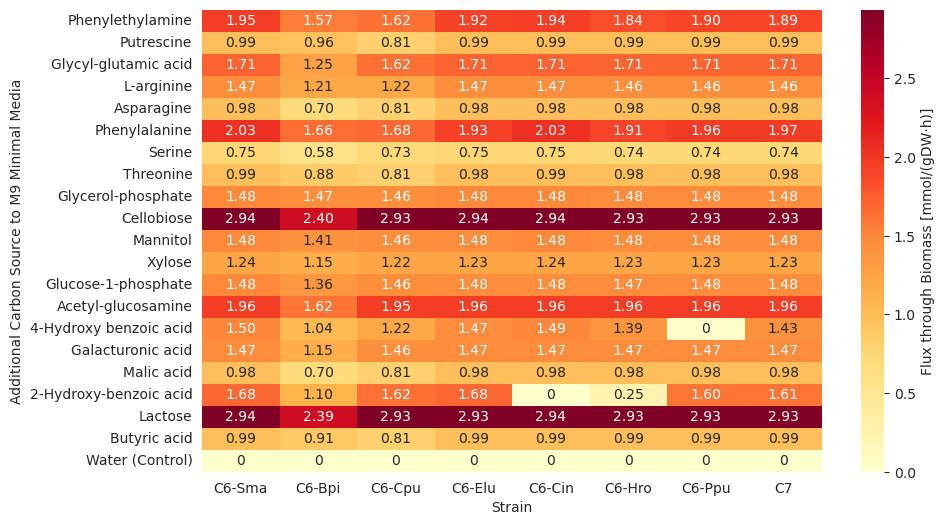

In [30]:
# for nicer visualisation: better labels
ecoplate_df.index = metab_axis
ecoplate_df.columns = ["C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu", "C7"]
ecoplate_df = ecoplate_df.fillna(0)
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ecoplate_df, annot=annot_str, fmt="", cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
#plt.yticks(ticks=np.arange(len(metab_axis)), labels=metab_axis)
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
plt.savefig("../Figures/dropouts_ecoplate.svg", format="svg", bbox_inches="tight")
plt.show()

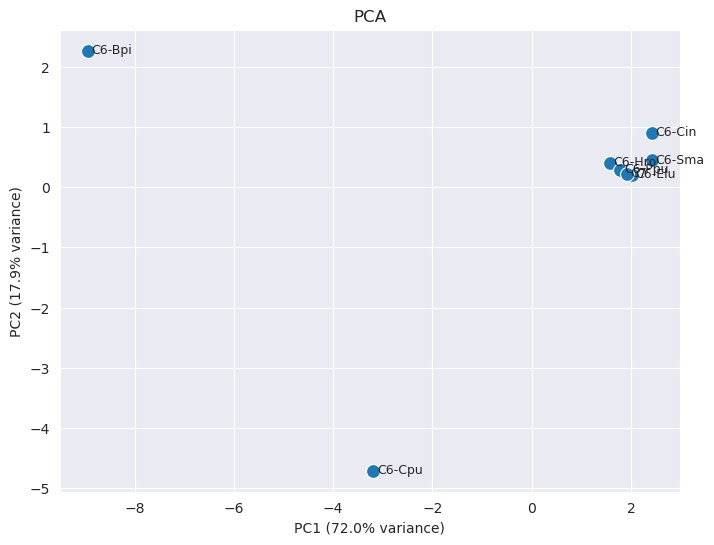

In [23]:
pca(ecoplate_df.T, save_path="../Figures/dropouts_ecoplate_PCA.svg")

[10/28/25 09:36:31] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=700010;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=708978;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:32] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=478245;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=461370;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:34] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=919035;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=976650;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:37] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=184711;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=381064;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:39] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=486541;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=805314;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:41] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=912031;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=768152;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:43] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=398311;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=510621;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

[10/28/25 09:36:44] WARNING  There does not seem to be any carbon source in your medium. Please    ]8;id=602826;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py\community.py]8;;\:]8;id=176849;file:///home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/micom/community.py#667\667]8;;\
                             double-check your medium IDs.                                                         

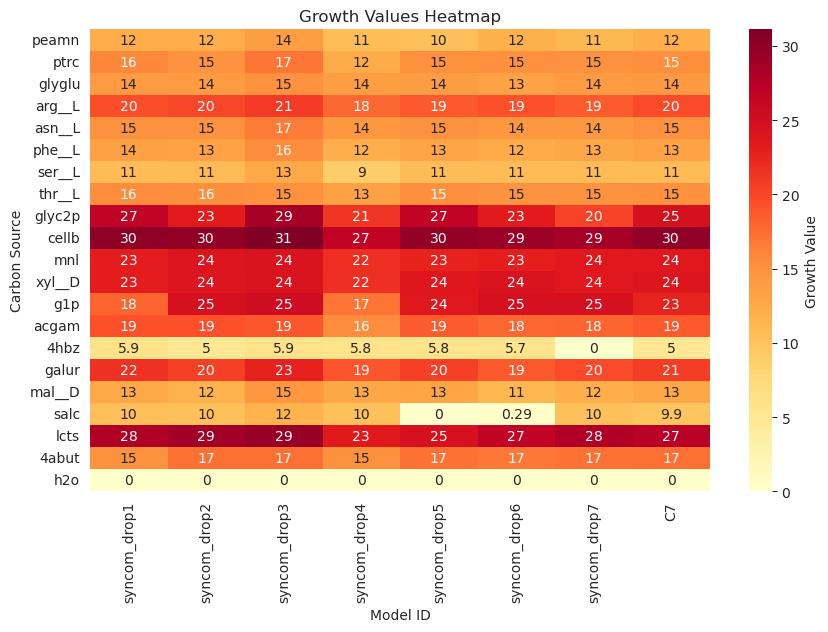

In [15]:
ecoplate_df_highcarbon = create_medium(ecoplate_rxns, m9_rxn, all_models, 1000, carbon_only=True, average="yes")

In [12]:
# Ensure numeric
ecoplate_df_highcarbon = ecoplate_df_highcarbon.apply(pd.to_numeric, errors='coerce')

def custom_format(x):
    if round(x, 1) == 0:
        return "0"  # no decimals for 0
    else:
        return f"{x:.1f}"  # 2 decimals otherwise

annot_str = ecoplate_df_highcarbon.applymap(custom_format)

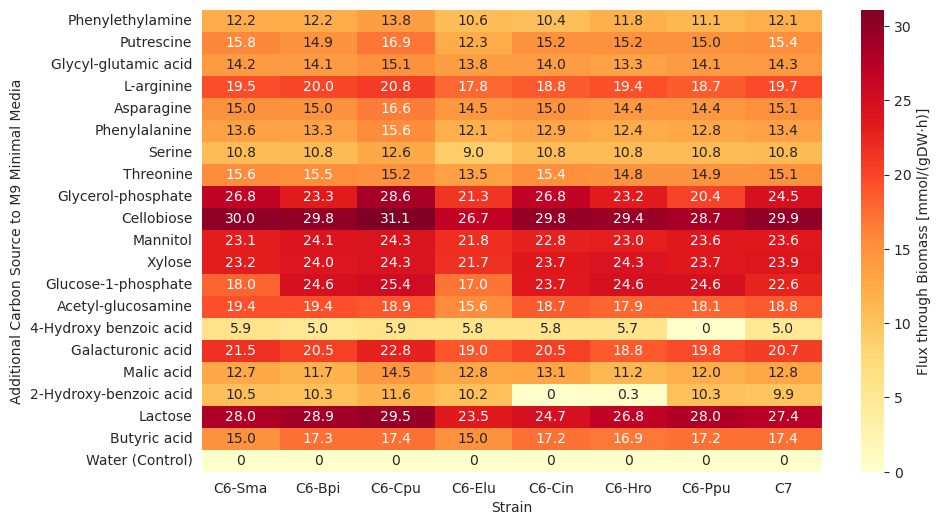

In [28]:
# for nicer visualisation: better labels
ecoplate_df_highcarbon.index = metab_axis
ecoplate_df_highcarbon.columns = ["C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu", "C7"]
ecoplate_df_highcarbon = ecoplate_df_highcarbon.fillna(0)
# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(ecoplate_df_highcarbon, annot=annot_str,fmt="", cmap="YlOrRd", cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'})
# plt.title("")
plt.xlabel("Strain")
#plt.yticks(ticks=np.arange(len(metab_axis)), labels=metab_axis)
plt.ylabel("Additional Carbon Source to M9 Minimal Media")
#plt.savefig("../Figures/MA_Results/dropouts_ecoplateHIGH.svg", format="svg", bbox_inches="tight")
plt.show()

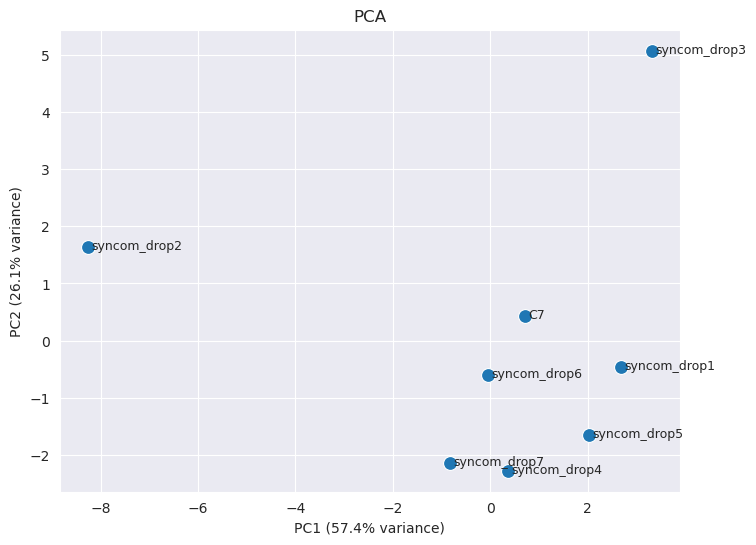

In [14]:
pca(ecoplate_df_highcarbon.T)
#pca(ecoplate_df_highcarbon.T, save_path="../Figures/dropouts_ecoplateHIGH_PCA.svg")

# Combine Heatmaps

In [26]:
growth_with_total = growth_krumbach_df.copy()

# First calculate the raw sum
growth_with_total["Total"] = growth_with_total.sum(axis=1)

# Adjust Total based on the index
def adjust_total(row):
    if "drop" in row.name:
        return row["Total"] / 6
    elif row.name == "C7_Community":
        return row["Total"] / 7
    else:
        return row["Total"]  # Leave unchanged if none of the above

# Apply the adjustment
growth_with_total["Total"] = growth_with_total.apply(adjust_total, axis=1)


In [27]:
# Create a mask for the last row ("Total")
mask_top = np.zeros_like(growth_with_total.T, dtype=bool)
mask_top[-1, :] = True  # mask the last row to avoid color distortion

In [28]:
# Custom axis labels
custom_labels_y = ["C7", "C6-Sma", "C6-Bpi", "C6-Cpu", "C6-Elu", "C6-Cin", "C6-Hro", "C6-Ppu"]
custom_labels_x = ["Sma", "Bpi", "Cpu", "Elu", "Cin", "Hro", "Ppu", "Community mean"]
#metab_axis = ["Phenylethylamine", "Putrescine", "Glycyl-glutamic acid", "L-arginine", "Asparagine", "Phenylalanine", "Serine", "Threonine", "Glycerol-phosphate", "Cellobiose", "mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "Galacturonic acid", "Malic acid", "2-Hydroxy-benzoic acid", "Lactose", "Butyric acid", "Water (Control)"]
metab_axis = ["Phenylethylamine", "Putrescine", "L-arginine", "Asparagine", "Phenylalanine", "Glycerol-phosphate", "Cellobiose", "Mannitol", "Xylose", "Glucose-1-phosphate", "Acetyl-glucosamine", "Galacturonic acid", "2-Hydroxy-benzoic acid", "Lactose", "Water (Control)"]

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of labels (15).

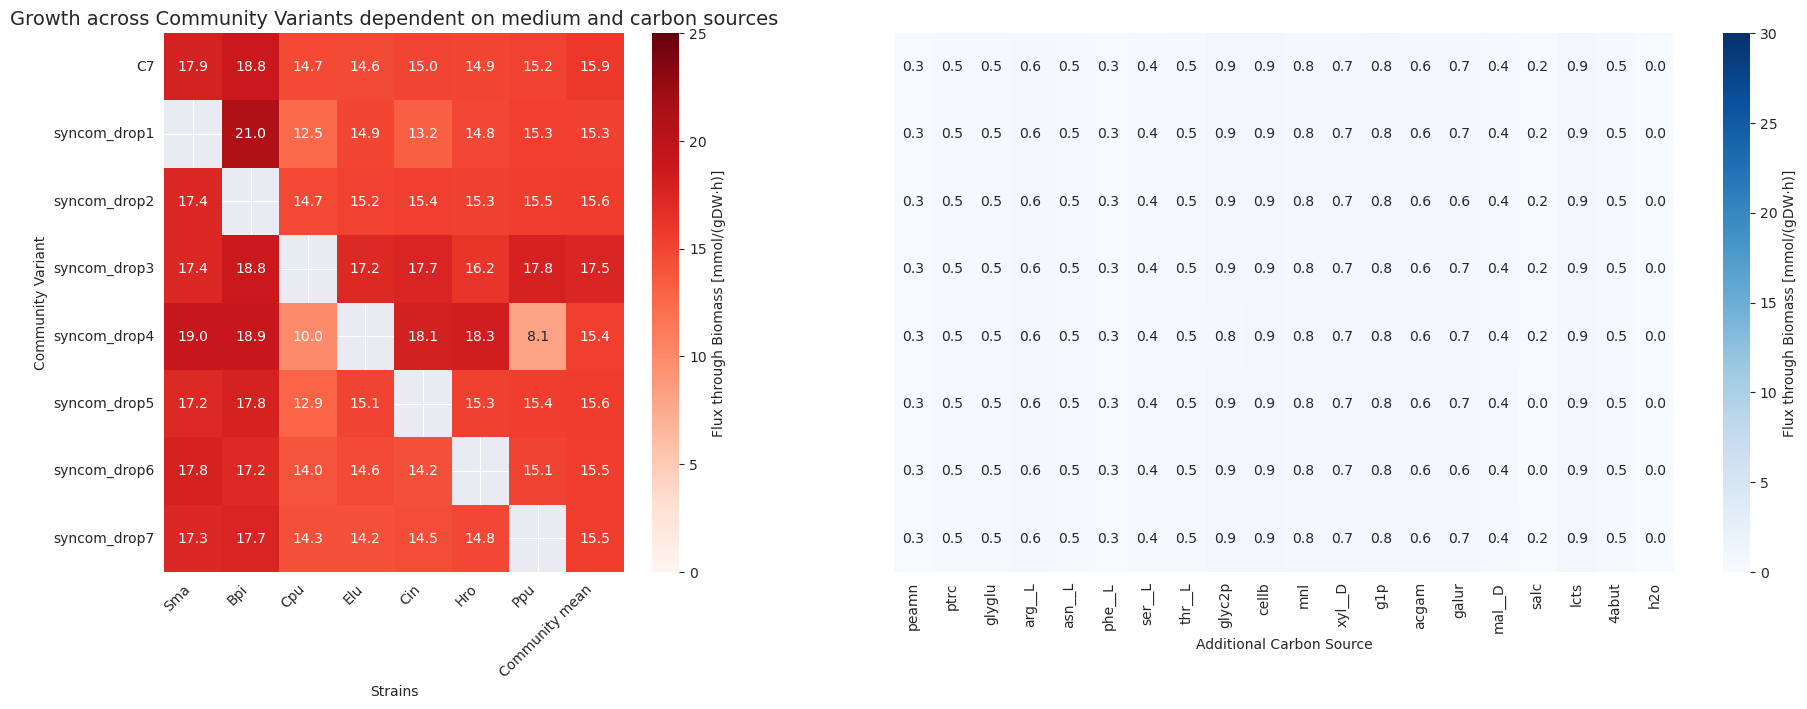

In [29]:
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(22, 7),
    sharey=True,
    gridspec_kw={'width_ratios': [1, 1.7]}
)

vmin = 0
vmax = 45
color_map1 = "Reds"
color_map2 = "Blues"

# --- First heatmap: Growth ---
sns.heatmap(
    growth_with_total,
    ax=ax1,
    cmap=color_map1,
    annot=True,
    fmt=".1f",
    vmin=0,
    vmax=25,
    cbar=True,
    cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'}
)
ax1.set_ylabel("Community Variant")
ax1.set_xlabel("Strains")
ax1.set_title("Growth across Community Variants dependent on medium and carbon sources", fontsize=14)
ax1.set_xticklabels(custom_labels_x, rotation=45, ha="right")
ax1.set_yticklabels(custom_labels_y, ha="right")

# --- Second heatmap: Metabolite Uptake ---
res_df_clean = res_df_avg[[res_df_avg.columns[-1]] + list(res_df_avg.columns[:-1])]
res_df_clean = res_df_clean.drop(index="4hbz", errors="ignore").fillna(0)
res_df_clean_T = res_df_clean.T

heatmap = sns.heatmap(
    res_df_clean_T,
    ax=ax2,
    cmap=color_map2,
    vmin=0,
    vmax=30,
    annot=True,
    fmt=".1f",
    cbar=True,
    cbar_kws={'label': 'Flux through Biomass [mmol/(gDW·h)]'}
)
ax2.set_xlabel("Additional Carbon Source")
#ax2.set_title("Metabolite Uptake across Community Variants", fontsize=14)
ax2.set_xticklabels(metab_axis, rotation=45, ha="right")
ax2.set_yticklabels(custom_labels_y, ha="right")  # Y is shared with ax1

# --- Shared colorbar ---
#cbar_ax = fig.add_axes([0.93, 0.25, 0.02, 0.5])
#fig.colorbar(heatmap.get_children()[0], cax=cbar_ax, label="Flux through Biomass\n[mmol/(gDW·h)]")

# --- Global super title ---
#fig.suptitle("Growth across Community Variants on", fontsize=16, fontweight='bold', y=0.98, x=0.42)

# --- Individual titles for each subplot ---
ax1.set_title("(a) Growth across Community Variants on Maize Root Exudate", fontsize=13)
ax2.set_title("(b) Growth across Community Variants on M9 Minimal Medium", fontsize=13)

# --- Layout ---
#plt.tight_layout(rect=[0, 0, 0.92, 1])
fig.subplots_adjust(wspace=0.05)

# --- Save & Show ---
plt.savefig("../Figures/combined_heatmap.svg", format="svg", bbox_inches="tight")
plt.show()


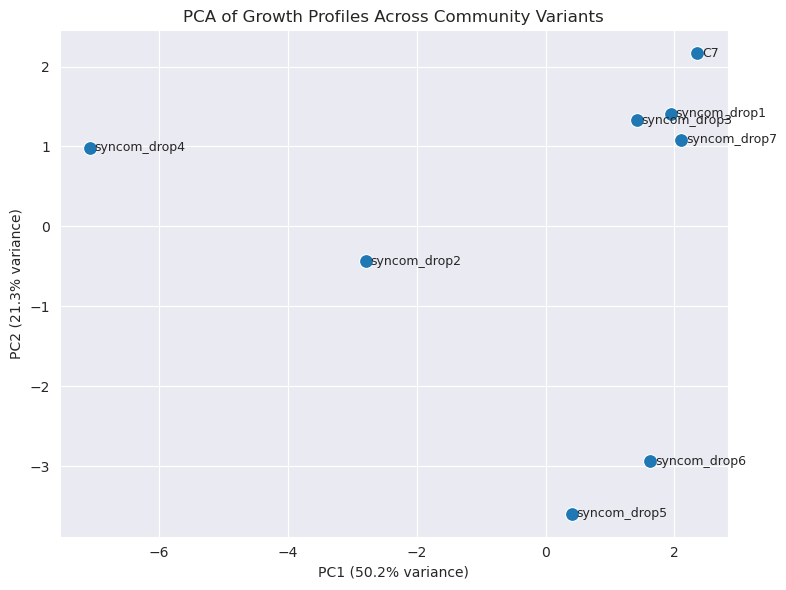

In [30]:
# Standardise the data
scaler = StandardScaler()
growth_df_filled = res_df_clean.T.fillna(0)
scaled_growth = scaler.fit_transform(growth_df_filled)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_growth)

# Create df for PCA result
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=res_df_clean.T.index)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", data=pca_df, s=100)

# Annotate each point with the community name
for name, row in pca_df.iterrows():
    if name != "C7_Community":
        plt.text(row["PC1"] + 0.07, row["PC2"]-0.04, name, fontsize=9)
    else:
        plt.text(row["PC1"] + -0.1, row["PC2"]+0.1, name, fontsize=9)

# Add variance explained info
pc1_var = pca.explained_variance_ratio_[0] * 100
pc2_var = pca.explained_variance_ratio_[1] * 100
plt.xlabel(f"PC1 ({pc1_var:.1f}% variance)")
plt.ylabel(f"PC2 ({pc2_var:.1f}% variance)")

plt.title("PCA of Growth Profiles Across Community Variants")
#plt.xlim(-3, 3)
#plt.ylim(-3, 2)
plt.grid(True)
plt.tight_layout()
#plt.savefig("../Figures/drop_outs_ecoplate_pca.svg", format="svg", bbox_inches="tight")
plt.show()

# Uptakes and Secretions

## One community within

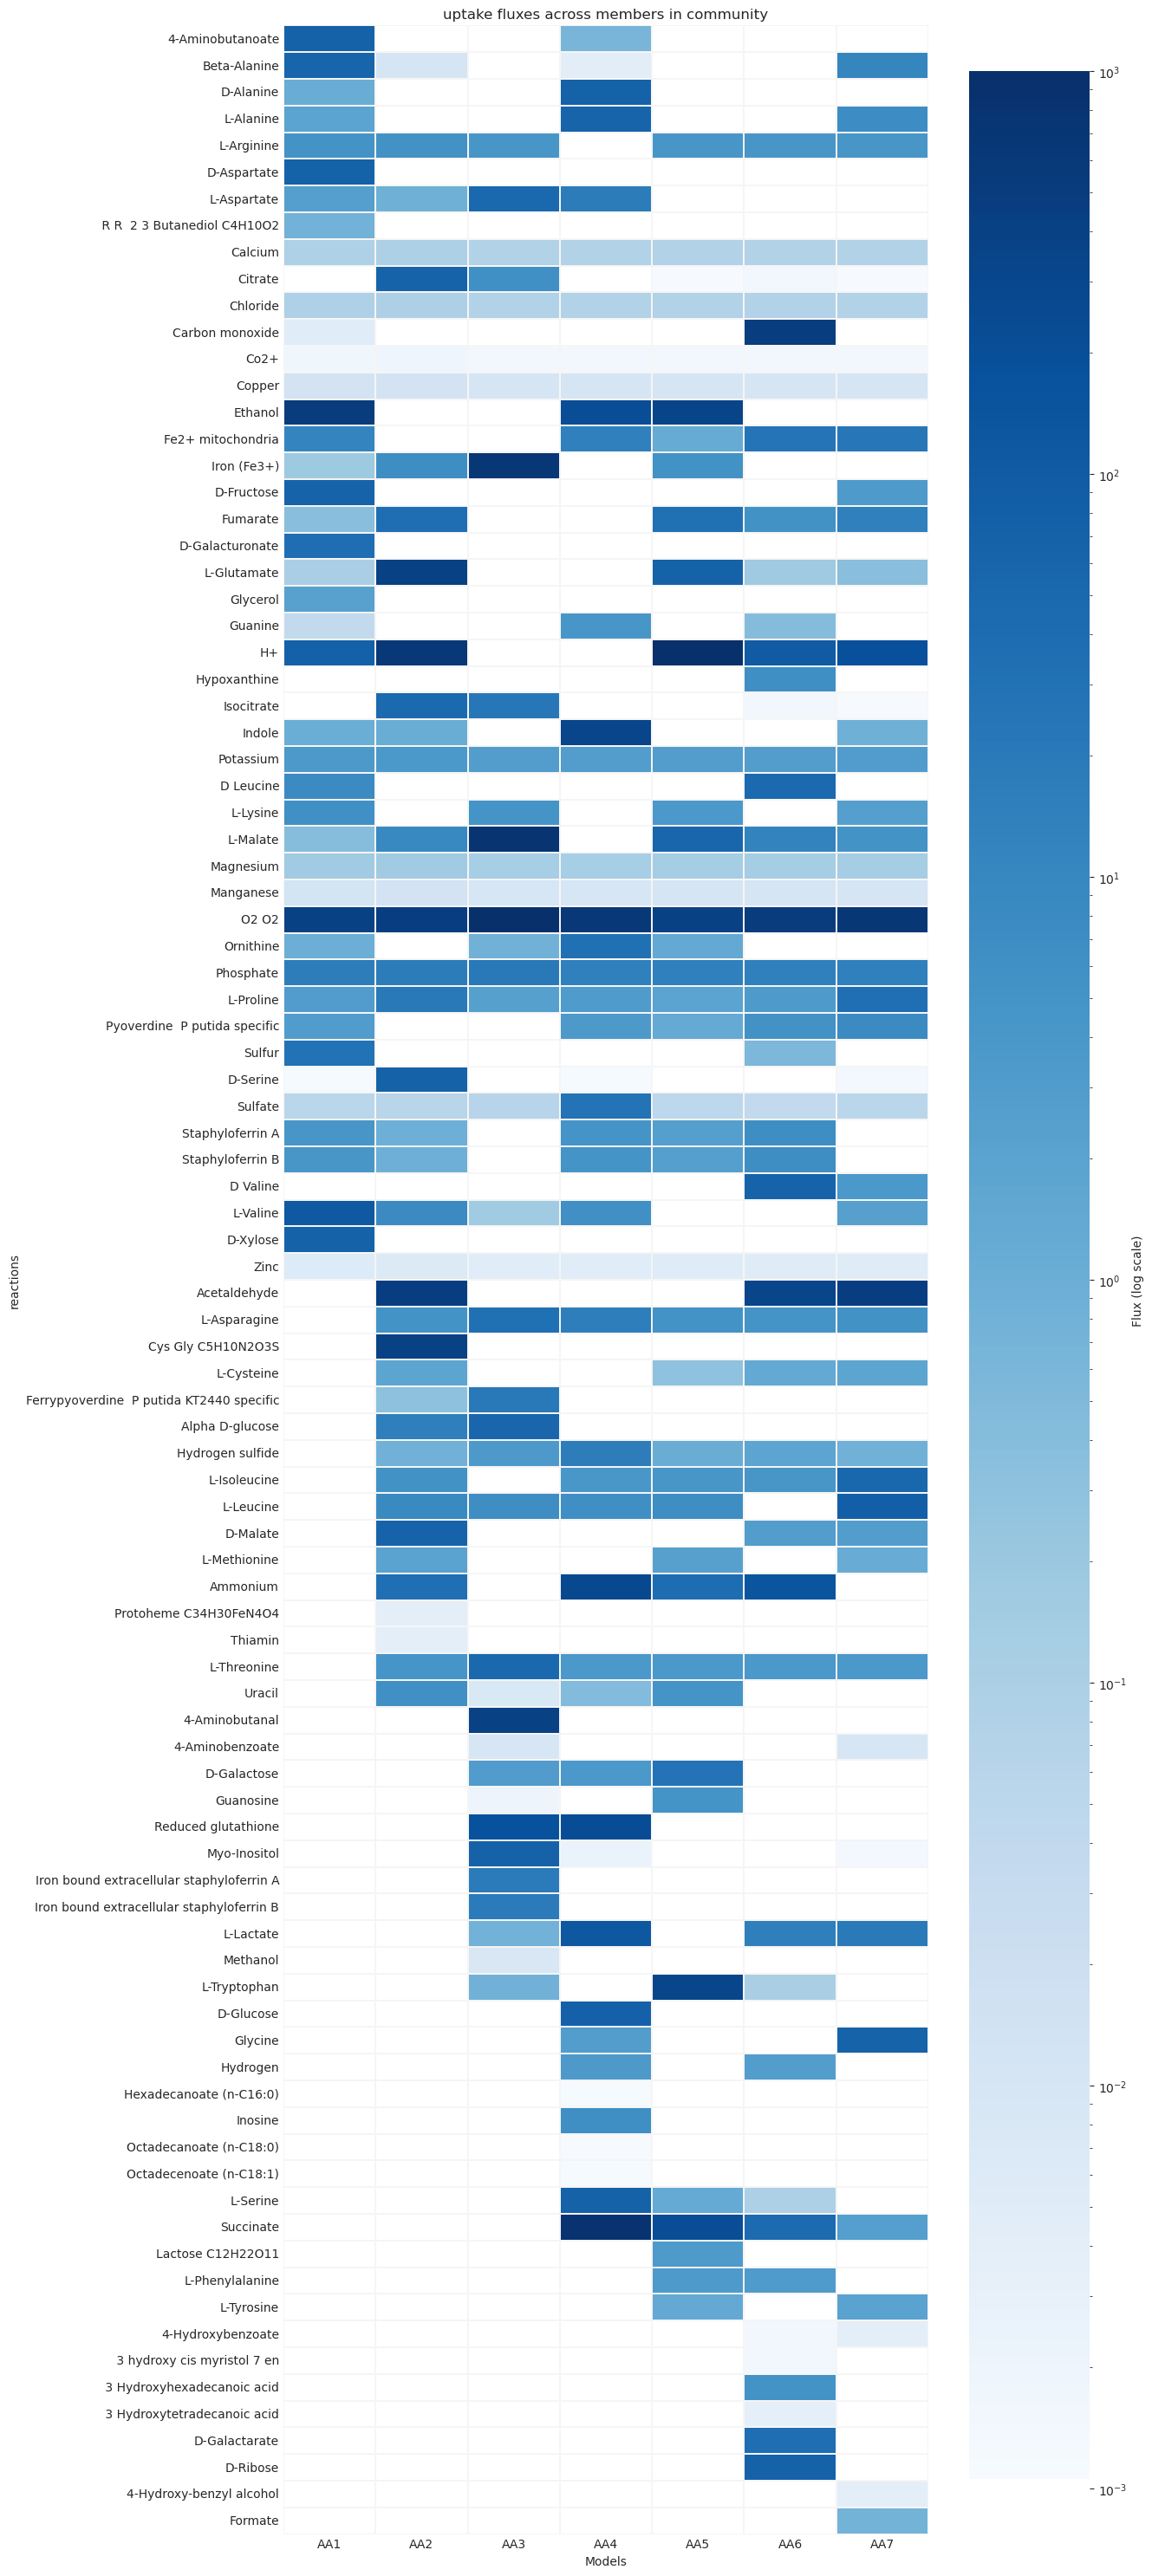

In [36]:
heatmap_fluxes_withinCommunity(syncom, models, medium_combined_krumbach, "uptake")

In [154]:
new_dict = {k: v for k, v in models.items() if k != "AA7"}

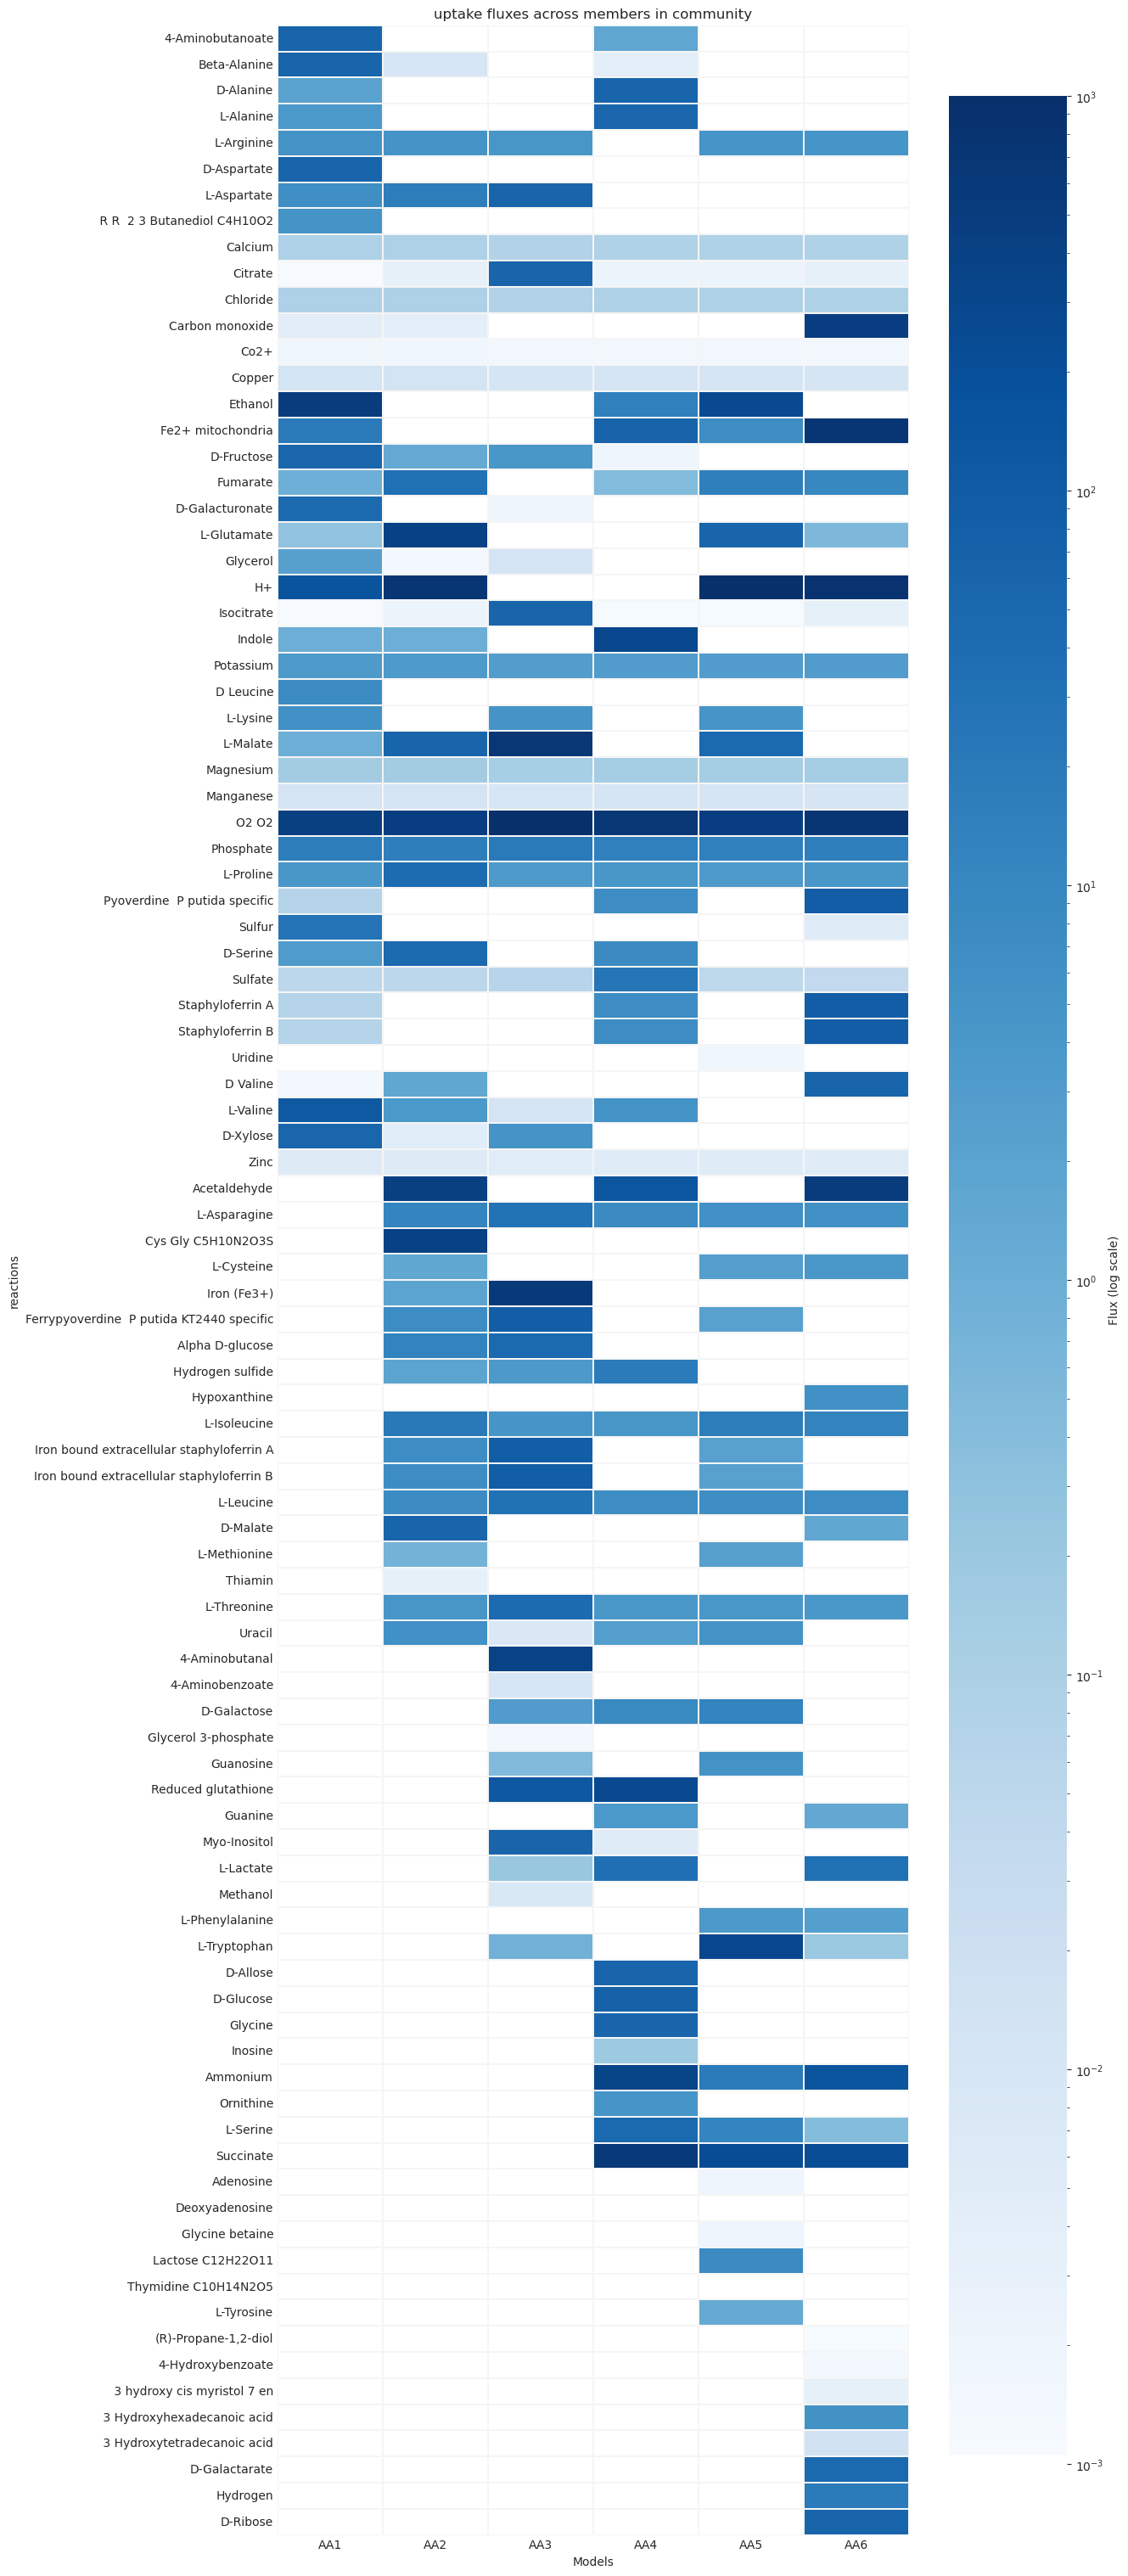

In [163]:
new_dict = {k: v for k, v in models.items() if k != "AA7"}
extra_all_up = heatmap_fluxes_withinCommunity(S7, new_dict, medium_combined_krumbach_all, "uptake")

In [40]:
syncom.reactions.query("EX_thm")

[<Reaction EX_thm_e__AA2 at 0x77497a8f2080>,
 <Reaction EX_thm_m at 0x7749790173a0>,
 <Reaction EX_thm_e__AA3 at 0x774978e8a980>,
 <Reaction EX_thm_e__AA4 at 0x774973e614e0>,
 <Reaction EX_thm_e__AA5 at 0x77497201d6f0>,
 <Reaction EX_thm_e__AA7 at 0x77496b956ec0>]

In [49]:
get_rxn(AA4, "PFL")

PFL: coa_c + pyr_c --> accoa_c + for_c


In [50]:
get_rxn_unknown(models, "PFL")

PFL is found in: ['AA4']
PFL: coa_c + pyr_c --> accoa_c + for_c


In [47]:
get_met(AA4, "for_c")

Formate (CHO2)
{'SFGTHi': 'Sfglutth_c + h2o_c --> for_c + gthrd_c + h_c', 'ALDD1': 'fald_c + h2o_c + nad_c --> for_c + 2.0 h_c + nadh_c', 'FORAMD': 'frmd_c + h2o_c --> for_c + nh4_c', 'FORtppi': 'for_c --> for_p', 'FORt2pp': 'for_p + h_p --> for_c + h_c', 'PFL': 'coa_c + pyr_c --> accoa_c + for_c', 'FTHFD': '10fthf_c + h2o_c --> for_c + h_c + thf_c', 'ARD_1': 'dhmtp_c + o2_c --> 2kmb_c + for_c + 2.0 h_c', 'OBTFL': '2obut_c + coa_c --> for_c + ppcoa_c', 'DB4PS': 'ru5p__D_c --> db4p_c + for_c + h_c', 'AMPMS2': 'air_c + h2o_c + nad_c --> 4ampm_c + 2.0 for_c + 3.0 h_c + nadh_c', 'FDH': 'for_c + nad_c --> co2_c + nadh_c', 'OXFOt4pp': 'for_c + oxa_p <=> for_p + oxa_c', 'GART': 'atp_c + for_c + gar_c --> adp_c + fgam_c + h_c + pi_c', 'GTPCI': 'gtp_c + h2o_c --> ahdt_c + for_c + h_c', 'GTPCII2': 'gtp_c + 3.0 h2o_c --> 25drapp_c + for_c + 2.0 h_c + ppi_c'}


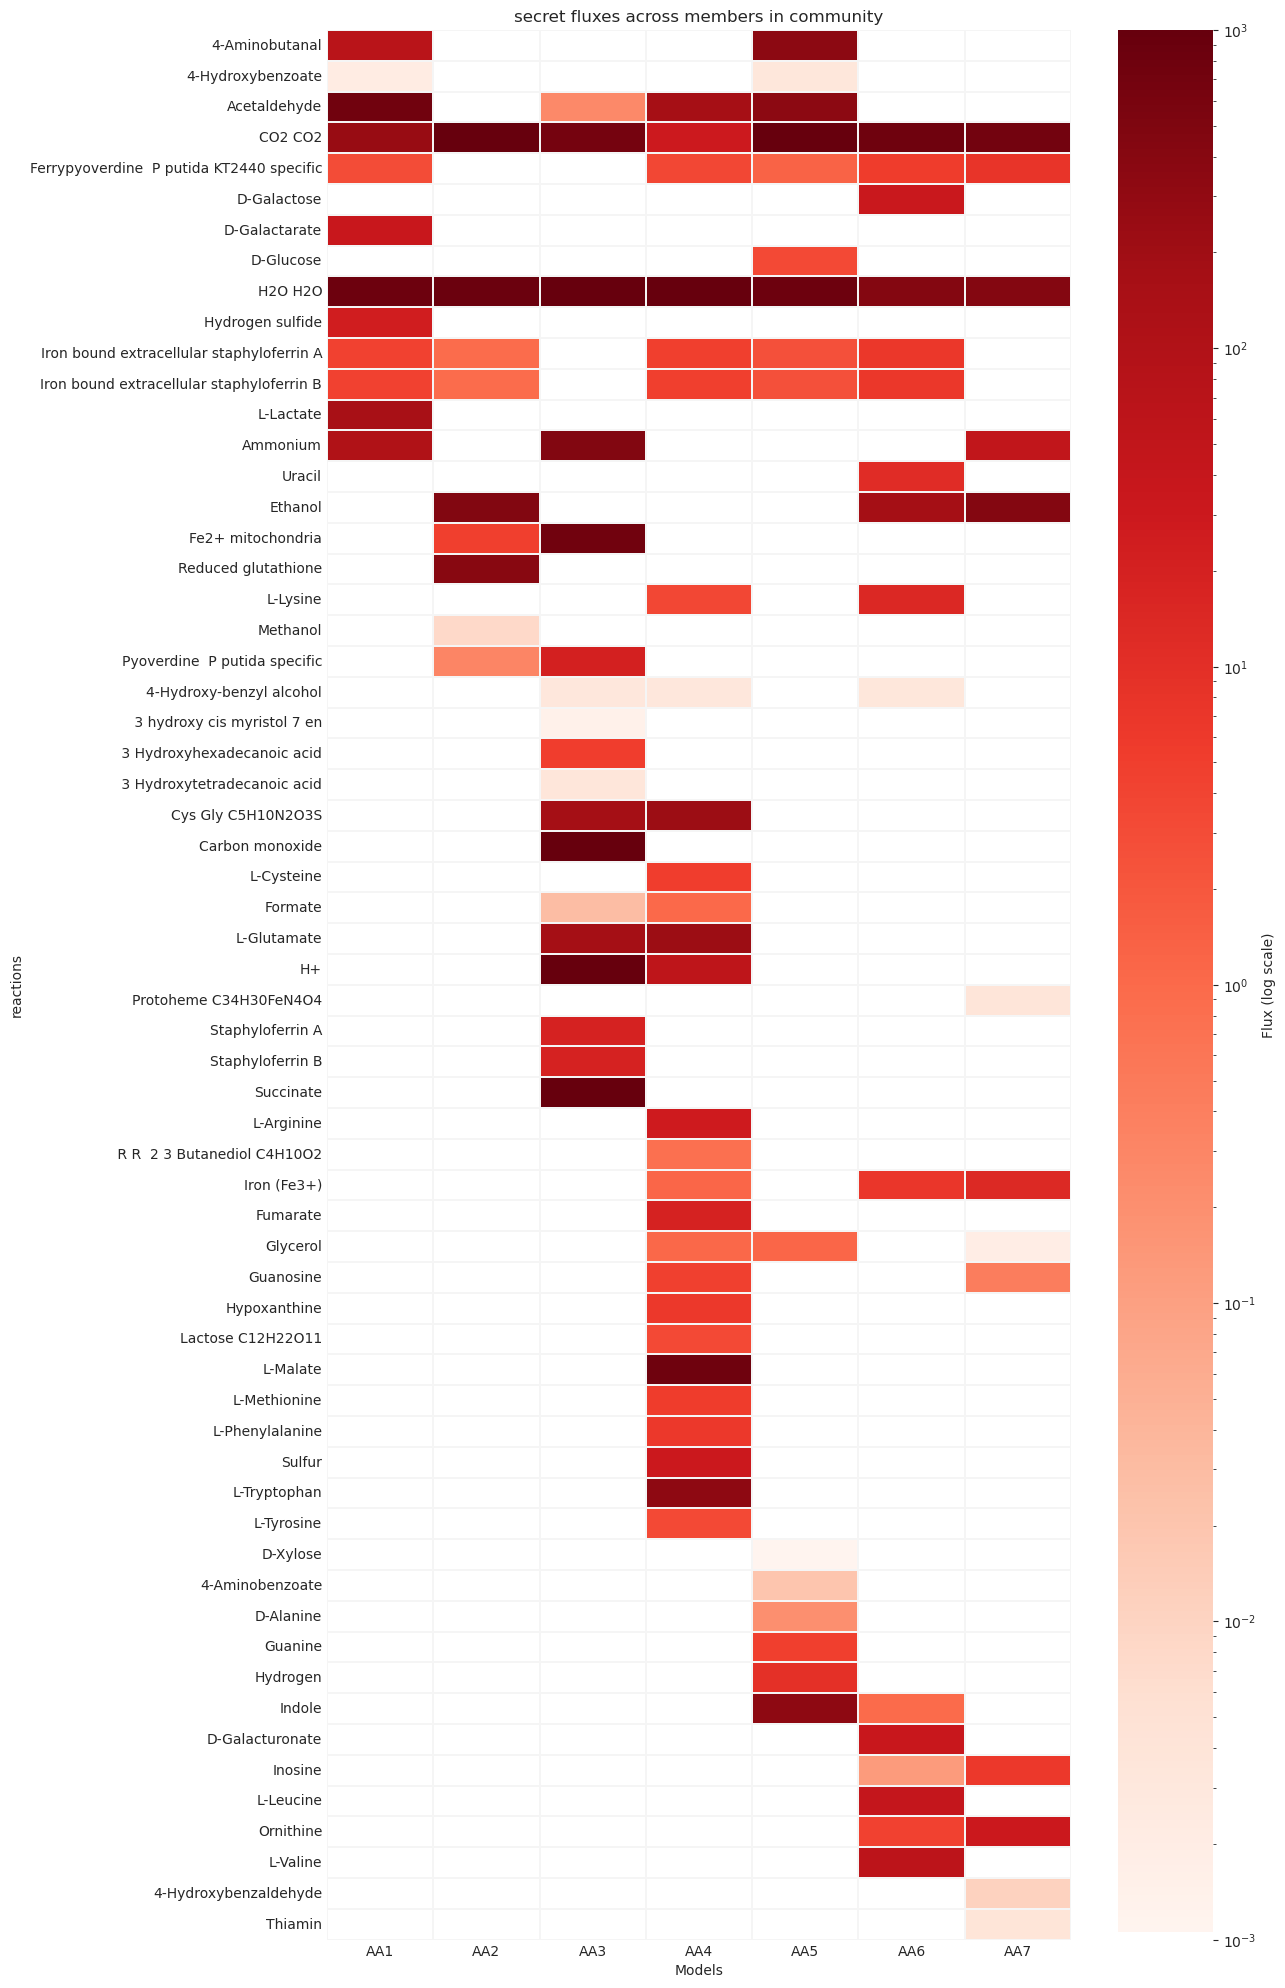

In [37]:
heatmap_fluxes_withinCommunity(syncom, models, medium_combined_krumbach, "secret")

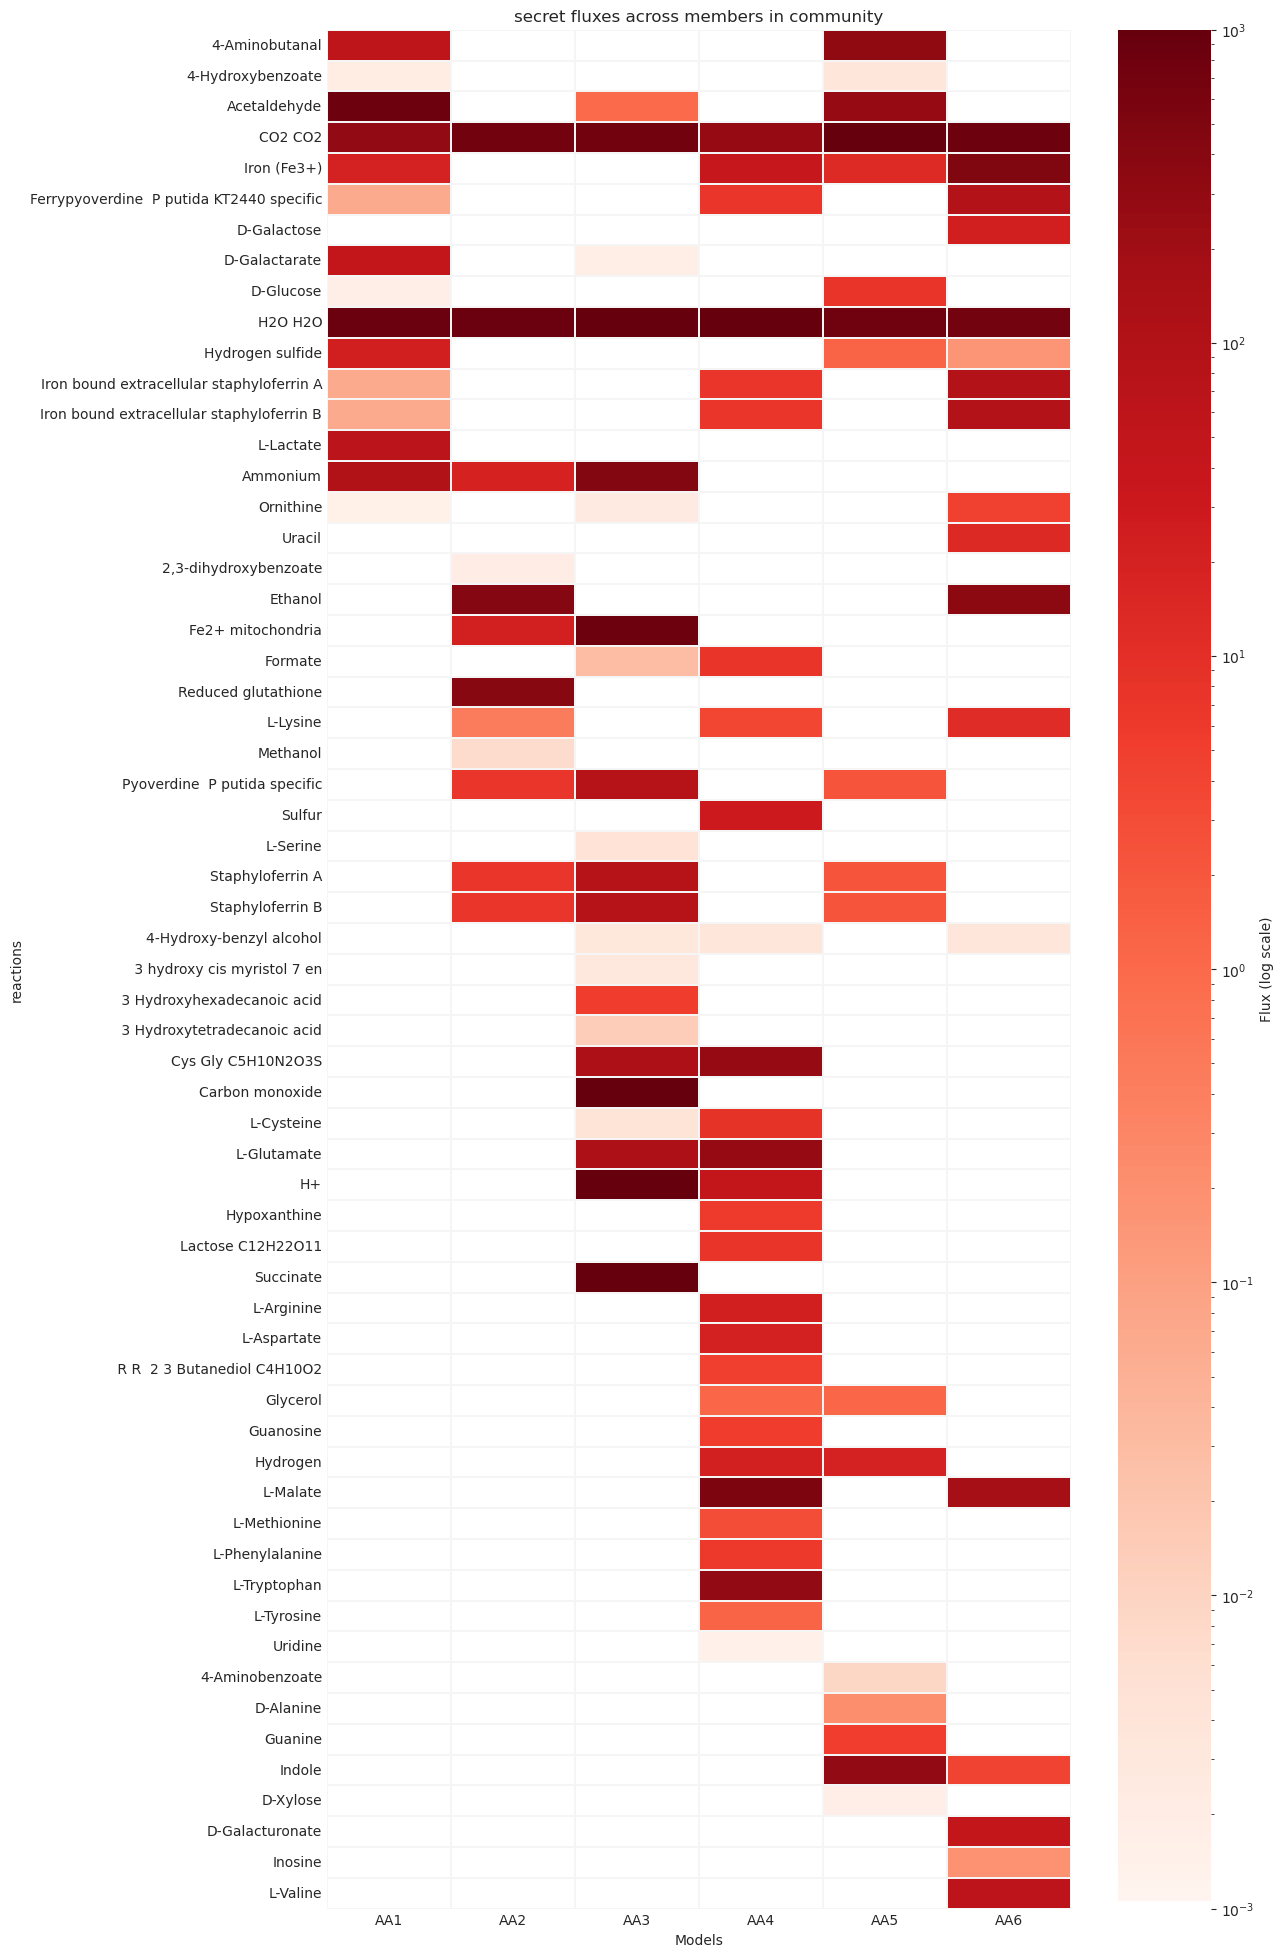

In [162]:
extra_all = heatmap_fluxes_withinCommunity(S7, new_dict, medium_combined_krumbach_all, "secret")

## across all drop out communities

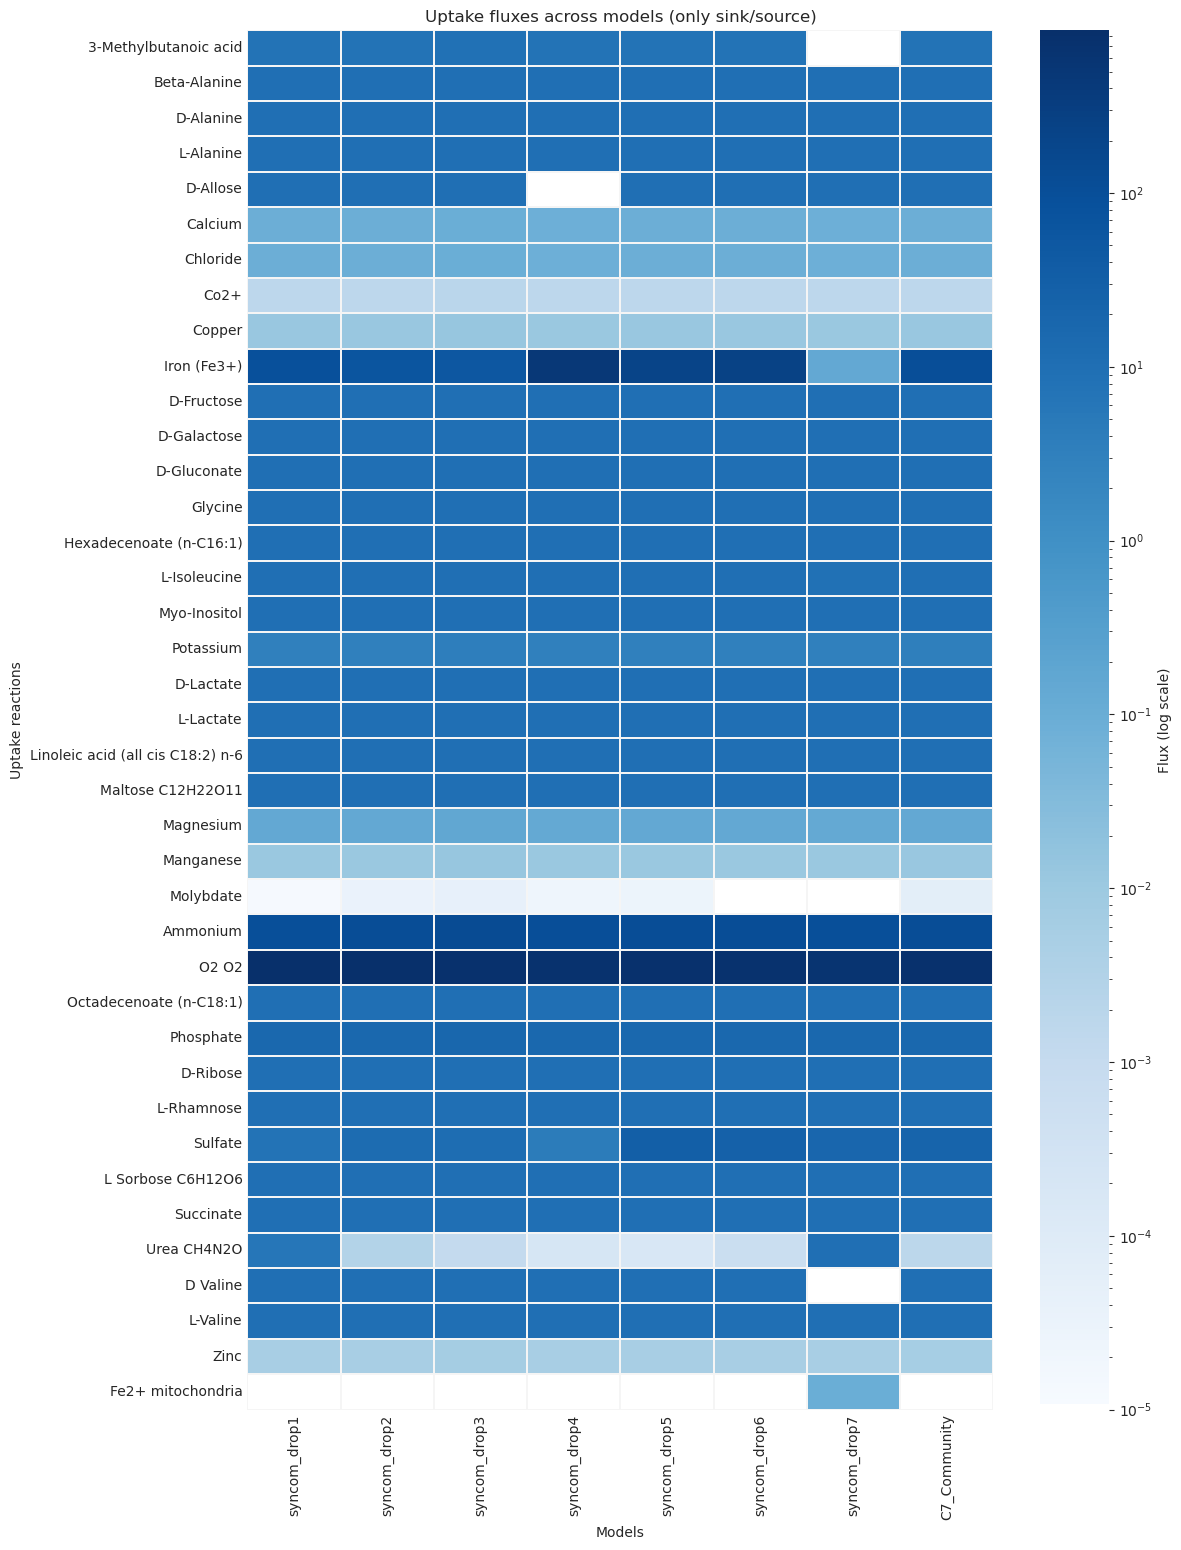

In [18]:
uptake_df_alldrops = uptake_secret_heatmap(all_models, "uptake", medium_combined_naveed, c7_all_ex = "no")

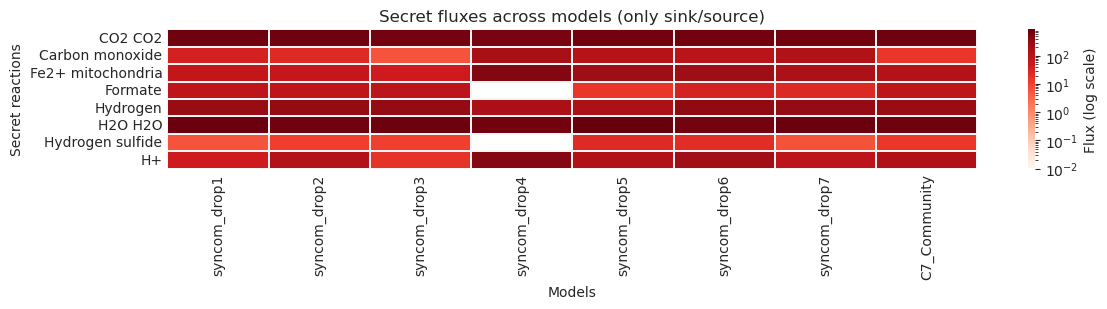

In [20]:
secret_df_alldrops = uptake_secret_heatmap(all_models, "secret", medium_combined_naveed, c7_all_ex = "no", vmin=0.01)

# S7 Investigation

In [48]:
taxonomy = pd.read_csv("../Datasets/community_model_gap_filled.csv", sep=";")
cut_tax = taxonomy.drop(index=taxonomy.index[6])
name = f"syncom_drop7"

S7 = Community(
    cut_tax.iloc[:, :-1],
    name="synthetic six member bacterial community",
    id=name,
    solver="cplex")

# Set EX reaction bounds for this syncom
for rxn in S7.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

In [8]:
taxonomy = pd.read_csv("../Datasets/community_model_noSucrose.csv", sep=";")
cut_tax = taxonomy.drop(index=taxonomy.index[6])
name = f"syncom_drop7_noS"

S7_noS = Community(
    cut_tax.iloc[:, :-1],
    name="synthetic six member bacterial community",
    id=name,
    solver="cplex")

# Set EX reaction bounds for this syncom
for rxn in S7_noS.reactions.query("^EX_"):
    rxn.lower_bound = -1000

Output()

## Sucrose

In [70]:
with S7_2:
    S7_2.reactions.EX_sucr_e__AA6.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    17.447225
AA2    18.221318
AA3    14.244316
AA4    13.839949
AA5    14.378256
AA6    14.846703
Name: Growth, dtype: float64


In [56]:
growth_val= test_medium(S7, medium_combined_krumbach)
print(growth_val)

model
AA1    15.097689
AA2    15.086133
AA3    15.097689
AA4    15.097689
AA5    15.097689
AA6    15.097689
Name: Growth, dtype: float64


In [55]:
growth_val_fixed = test_medium(S7_2, medium_combined_krumbach)
print(growth_val_fixed)

model
AA1    17.340410
AA2    17.670702
AA3    14.339311
AA4    14.229205
AA5    14.545219
AA6    14.836640
Name: Growth, dtype: float64


In [33]:
sum(growth_val_fixed)

90.57457552668428

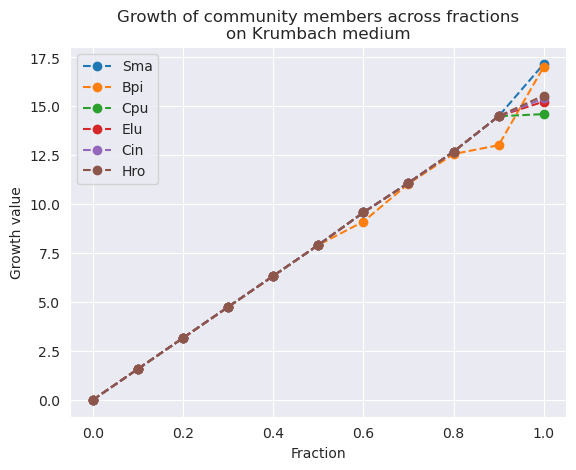

In [16]:
test_fractions_community(S7, medium_combined_krumbach_all, drop_out="Ppu", medium_name="Krumbach + Allose")

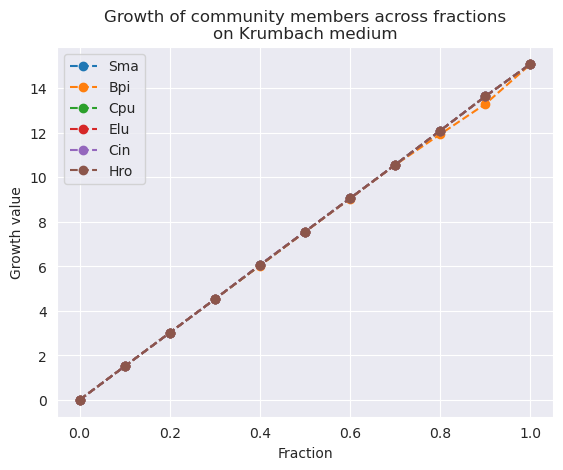

In [10]:
test_fractions_community(S7, medium_combined_krumbach, drop_out="Ppu", medium_name="Krumbach")

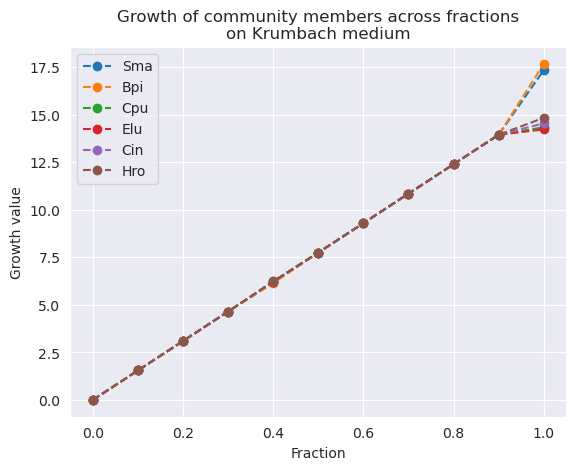

In [11]:
test_fractions_community(S7_noS, medium_combined_krumbach, drop_out="Ppu", medium_name="Krumbach")

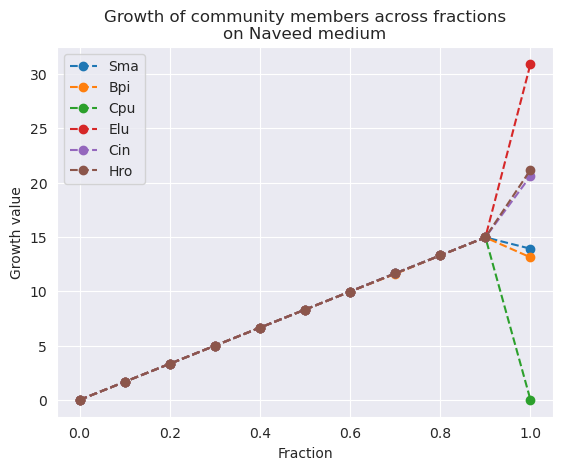

In [14]:
test_fractions_community(S7, medium_combined_naveed, drop_out="Ppu", medium_name="Naveed")

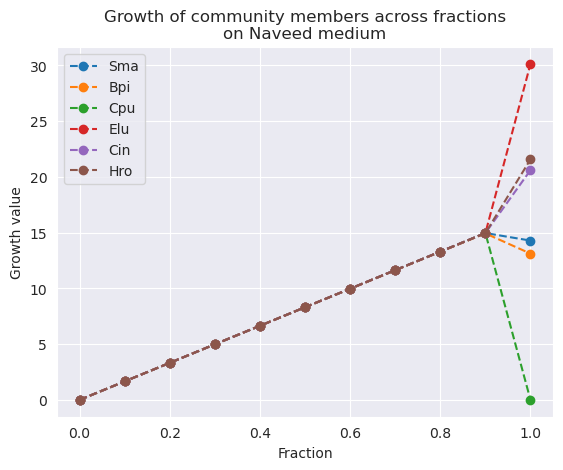

In [15]:
test_fractions_community(S7_noS, medium_combined_naveed, drop_out="Ppu", medium_name="Naveed")

### FVA

In [12]:
with S7:
    change_medium(S7, medium_combined_krumbach)
    fva_s7_filled = flux_variability_analysis(S7)

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserW

In [13]:
#fva_s7_filled.to_csv("../FVA_DropOut7_GapFilled_Krumbach.csv", sep=";")

In [14]:
with S7_noS:
    change_medium(S7_noS, medium_combined_krumbach)
    fva_s7_noSucrose = flux_variability_analysis(S7_noS)

/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
/home/lisa/miniconda3/envs/MA/lib/python3.10/site-packages/cobra/util/solver.py:554: UserW

In [15]:
#fva_s7_noSucrose.to_csv("../FVA_DropOut7_FixesButNotSucrose_Krumbach.csv", sep=";")

In [23]:
fva_s7_noSucrose = pd.read_csv("../FVA_DropOut7_FixesButNotSucrose_Krumbach.csv", sep=";", index_col=0)
fva_s7_filled = pd.read_csv("../FVA_DropOut7_GapFilled_Krumbach.csv", sep=";", index_col=0)

In [24]:
fva_s7_noSucrose = fva_s7_noSucrose.round(5)
fva_s7_filled = fva_s7_filled.round(5)

Check which reactions always have the same flux value (that is not zero), aka what are essential reactions

In [19]:
# mask for rows where minimum == maximum and not 0
mask = (fva_s7_noSucrose["minimum"] == fva_s7_noSucrose["maximum"]) & (fva_s7_noSucrose["minimum"] != 0)

# filter rows
identical_rows = fva_s7_noSucrose[mask]

# print index and the identical value
for idx, row in identical_rows.iterrows():
    print(idx, row["minimum"])

EX_4abut_e__AA1 -60.0
EX_4abutn_e__AA1 60.0
EX_arg__L_e__AA1 -5.35202
EX_asp__D_e__AA1 -60.0
EX_ca2_e__AA1 -0.09418
EX_cl_e__AA1 -0.09418
EX_cobalt2_e__AA1 -0.00181
EX_cu2_e__AA1 -0.01283
EX_fru_e__AA1 -60.0
EX_glyc_e__AA1 -2.39852
EX_gua_e__AA1 -4.40094
EX_hxan_e__AA1 -1.71685
EX_indole_e__AA1 -1.02851
EX_k_e__AA1 -3.5318
EX_leu__D_e__AA1 -8.15185
EX_lys__L_e__AA1 -6.20911
EX_mg2_e__AA1 -0.15696
EX_mn2_e__AA1 -0.0125
EX_pi_e__AA1 -17.44309
EX_xyl__D_e__AA1 -60.0
EX_zn2_e__AA1 -0.00617
3HAACOAT140__AA1 -1.40814
4HBADH__AA1 0.00403
4HBZt3pp__AA1 0.00223
4HBZtex__AA1 -0.00223
A5PISO__AA1 0.70407
AACPS3__AA1 5.03111
ADCL__AA1 0.0121
ADCS__AA1 0.0121
ADSL1r__AA1 5.4107
ADSL2r__AA1 1.97968
ADSS__AA1 5.4107
AGPAT160__AA1 2.51556
AHCi__AA1 0.00543
AICART__AA1 3.69385
AIRCr__AA1 1.97968
ALAALAr__AA1 0.50279
ALAS__AA1 0.03228
APPAT__AA1 0.01042
APRAUR__AA1 0.00807
ASAD__AA1 -13.13458
ASLP__AA1 5.98536
ASNS2__AA1 4.36162
ASPDTDe__AA1 -60.0
ASPK__AA1 13.13458
ASPR__AA1 60.0
ATPPRT__AA1 1.71418
AT

In [20]:
# mask for rows where minimum == maximum and not 0
mask = (fva_s7_filled["minimum"] == fva_s7_filled["maximum"]) & (fva_s7_filled["minimum"] != 0)

# filter rows
identical_rows = fva_s7_filled[mask]

# print index and the identical value
for idx, row in identical_rows.iterrows():
    print(idx, row["minimum"])

EX_4abut_e__AA1 -60.0
EX_4abutn_e__AA1 60.0
EX_4hbz_e__AA1 0.00223
EX_arg__L_e__AA1 -5.35202
EX_asp__D_e__AA1 -60.0
EX_ca2_e__AA1 -0.09418
EX_cl_e__AA1 -0.09418
EX_cobalt2_e__AA1 -0.00181
EX_cu2_e__AA1 -0.01283
EX_fru_e__AA1 -60.0
EX_glyc_e__AA1 -2.39852
EX_gua_e__AA1 -4.40094
EX_hxan_e__AA1 -1.71685
EX_indole_e__AA1 -1.02851
EX_k_e__AA1 -3.5318
EX_leu__D_e__AA1 -8.15185
EX_lys__L_e__AA1 -6.20911
EX_mg2_e__AA1 -0.15696
EX_mn2_e__AA1 -0.0125
EX_pi_e__AA1 -17.44309
EX_xyl__D_e__AA1 -60.0
EX_zn2_e__AA1 -0.00617
3HAACOAT140__AA1 -1.40814
4HBADH__AA1 0.00403
4HBZt3pp__AA1 0.00223
4HBZtex__AA1 -0.00223
A5PISO__AA1 0.70407
AACPS3__AA1 5.03111
ADCL__AA1 0.0121
ADCS__AA1 0.0121
ADSL1r__AA1 5.4107
ADSL2r__AA1 1.97968
ADSS__AA1 5.4107
AGPAT160__AA1 2.51556
AHCi__AA1 0.00543
AICART__AA1 3.69385
AIRCr__AA1 1.97968
ALAALAr__AA1 0.50279
APPAT__AA1 0.01042
APRAUR__AA1 0.00807
ASAD__AA1 -13.13458
ASLP__AA1 5.98536
ASNS2__AA1 4.36162
ASPDTDe__AA1 -60.0
ASPK__AA1 13.13458
ASPR__AA1 60.0
ATPPRT__AA1 1.714

get Reactions where min == max != 0 that are unique to that model \
--> what are differences between models \
--> are there other reactions active

In [24]:
# mask for fixed nonzero fluxes
mask_filled = (fva_s7_filled["minimum"] == fva_s7_filled["maximum"]) & (fva_s7_filled["minimum"] != 0)
mask_noSucrose = (fva_s7_noSucrose["minimum"] == fva_s7_noSucrose["maximum"]) & (fva_s7_noSucrose["minimum"] != 0)

# extract indices and values
fixed_filled = fva_s7_filled[mask_filled]["minimum"]
fixed_noSucrose = fva_s7_noSucrose[mask_noSucrose]["minimum"]

# find unique reactions
unique_to_filled = fixed_filled.drop(index=fixed_noSucrose.index, errors="ignore").sort_index()
unique_to_noSucrose = fixed_noSucrose.drop(index=fixed_filled.index, errors="ignore").sort_index()

print("Unique to filled model:")
print(unique_to_filled)

print("\nUnique to noSucrose model:")
print(unique_to_noSucrose)


Unique to filled model:
4HTHRK__AA5          0.01439
ADCL__AA5            0.01744
AHMMPS_1__AA4        0.00351
AHMMPS_1__AA5        0.00360
AI2K__AA4            0.00860
ATPPRT__AA3          0.94136
BZSCD__AA1           0.00161
CPPPGO__AA5          0.00360
D5KGK__AA3          60.00000
DHPS__AA1            0.01210
DHPS__AA5            0.01079
DHPS__AA6            0.02051
EX_4hbz_e__AA1       0.00223
EX_bz_e__AA5        -0.00161
EX_gal_e__AA3       -2.03698
EX_ile__L_e__AA3    -3.08954
FCLT__AA4            0.00351
PDX5POi__AA5         0.01439
PMEVK__AA5           0.01291
PSCVT__AA5           0.01744
SHK3Dr__AA5          0.01744
UPP3S__AA1           0.00403
UPPDC1__AA5          0.00360
Name: minimum, dtype: float64

Unique to noSucrose model:
4HTHRA__AA5    -0.01439
ADNK1__AA4      0.00860
ALAS__AA1       0.03228
BZSS__AA1       0.00161
CHORS__AA5      0.01744
CPPPGO__AA6     0.00684
DHNPA_1__AA1    0.01210
DHORTS__AA4    -5.21205
FCLT__AA5       0.00360
HMBS__AA1       0.00403
HMPK1__AA4 

what reactions have zero flux in one model and non zero flux in the other

In [28]:
# get common indices
common_idx = fva_s7_filled.index.intersection(fva_s7_noSucrose.index)

# restrict both dfs to common indices
fva_s7_filled_common = fva_s7_filled.loc[common_idx]
fva_s7_noSucrose_common = fva_s7_noSucrose.loc[common_idx]

# masks for 0/0 rows
mask_filled_zero = (fva_s7_filled_common["minimum"] == 0) & (fva_s7_filled_common["maximum"] == 0)
mask_noSucrose_zero = (fva_s7_noSucrose_common["minimum"] == 0) & (fva_s7_noSucrose_common["maximum"] == 0)

# Case 1: zero in filled but nonzero in noSucrose
case1 = fva_s7_noSucrose_common[mask_filled_zero & ~mask_noSucrose_zero][["minimum"]].copy()
#case1 = case1.rename(columns={"minimum": "nonzero_value"})
#case1 = case1.reset_index().rename(columns={"index": "reaction_id"})

# Case 2: zero in noSucrose but nonzero in filled
case2 = fva_s7_filled_common[mask_noSucrose_zero & ~mask_filled_zero][["minimum"]].copy()
#case2 = case2.rename(columns={"minimum": "nonzero_value"})
#case2 = case2.reset_index().rename(columns={"index": "reaction_id"})

print("Zero in filled but nonzero in noSucrose:")
print(case1)

print("\nZero in noSucrose but nonzero in filled:")
print(case2)

Zero in filled but nonzero in noSucrose:
Empty DataFrame
Columns: [minimum]
Index: []

Zero in noSucrose but nonzero in filled:
Empty DataFrame
Columns: [minimum]
Index: []


get unique reactions of each model and check if they have flux at all \
--> are the sucrose reactions that i am deleting even used?? \
--> apparently not??

In [29]:
# get reactions unique to each df
unique_filled = fva_s7_filled.index.difference(fva_s7_noSucrose.index)
unique_noSucrose = fva_s7_noSucrose.index.difference(fva_s7_filled.index)

# filter df to only unique reactions
filled_unique_df = fva_s7_filled.loc[unique_filled]
noSucrose_unique_df = fva_s7_noSucrose.loc[unique_noSucrose]

# keep only rows where min/max are nonzero
filled_nonzero_unique = filled_unique_df[(filled_unique_df["minimum"] != 0) | (filled_unique_df["maximum"] != 0)].copy()
noSucrose_nonzero_unique = noSucrose_unique_df[(noSucrose_unique_df["minimum"] != 0) | (noSucrose_unique_df["maximum"] != 0)].copy()

# reset index to have reaction_id as a column
filled_nonzero_unique = filled_nonzero_unique.reset_index().rename(columns={"index": "reaction_id"})
noSucrose_nonzero_unique = noSucrose_nonzero_unique.reset_index().rename(columns={"index": "reaction_id"})

print("Unique reactions in filled with nonzero min/max:")
print(filled_nonzero_unique)

print("\nUnique reactions in noSucrose with nonzero min/max:")
print(noSucrose_nonzero_unique)

Unique reactions in filled with nonzero min/max:
Empty DataFrame
Columns: [reaction_id, minimum, maximum]
Index: []

Unique reactions in noSucrose with nonzero min/max:
Empty DataFrame
Columns: [reaction_id, minimum, maximum]
Index: []


In [32]:
with S7:
    change_medium(S7, medium_combined_krumbach)
    s7_fluxies = pfba(S7).fluxes

    filtered = s7_fluxies[s7_fluxies.index.str.contains("Growth")]
    print(filtered)

Growth__AA1    15.562122
Growth__AA2    17.478333
Growth__AA3     0.306085
Growth__AA4    21.924719
Growth__AA5    17.480835
Growth__AA6    17.822482
Name: fluxes, dtype: float64


In [50]:
with S7:
    #change_medium(S7, medium_combined_naveed)
    s7_fluxies = convert_cooptradeoff_into_fluxes(S7, medium_combined_naveed, frac=1)

    filtered = s7_fluxies[s7_fluxies.index.str.contains("Growth")]
    print(filtered)

reaction_id
Growth__AA1    13.917679
Growth__AA2    13.123485
Growth__AA3     0.000255
Growth__AA4    30.925755
Growth__AA5    20.607446
Growth__AA6    21.176536
Name: flux, dtype: float64


In [41]:
with S7:
    change_medium(S7, medium_combined_krumbach)
    s7_fluxies = pfba(S7).fluxes

    filtered = s7_fluxies[s7_fluxies.index.str.contains("Growth")]
    print(filtered)

Growth__AA1    15.562122
Growth__AA2    17.478333
Growth__AA3     0.306085
Growth__AA4    21.924719
Growth__AA5    17.480835
Growth__AA6    17.822482
Name: fluxes, dtype: float64


## Rest

In [102]:
S7_flux, S7_growth = community_pfba(S7, medium_combined_krumbach, frac=1)

In [42]:
S7_flux_n, S7_growth_n = community_pfba(S7, medium_combined_naveed, frac=1)

In [159]:
S7_flux_a, S7_growth_a = community_pfba(S7, medium_combined_krumbach_all, frac=1)

In [160]:
S7_growth_a

model
AA1    17.169163
AA2    17.026604
AA3    14.603961
AA4    15.244356
AA5    15.406500
AA6    15.555096
Name: Growth, dtype: float64

In [103]:
S7_growth

model
AA1    15.097689
AA2    15.086133
AA3    15.097689
AA4    15.097689
AA5    15.097689
AA6    15.097689
Name: Growth, dtype: float64

In [43]:
S7_growth_n

model
AA1    13.917679
AA2    13.123485
AA3     0.000255
AA4    30.925755
AA5    20.607446
AA6    21.176536
Name: Growth, dtype: float64

In [44]:
C7_flux, C7_growth = community_pfba(syncom, medium_combined_krumbach)

In [46]:
C7_growth

model
AA1    17.872568
AA2    18.789145
AA3    14.676160
AA4    14.651256
AA5    15.022124
AA6    14.943325
AA7    15.188754
Name: Growth, dtype: float64

In [45]:
C7_df_reset = C7_flux.reset_index().rename(columns={"reaction": "rxn_id"})
S7_df_reset = S7_flux.reset_index().rename(columns={"reaction": "rxn_id"})
S7_df_reset_n = S7_flux_n.reset_index().rename(columns={"reaction": "rxn_id"})

In [49]:
merged = S7_df_reset_n.merge(S7_df_reset, on="rxn_id", suffixes=("_S7n", "_S7"))

# Compare medium fluxes
merged["medium_diff"] = merged["medium_S7n"] - merged["medium_S7"]

# Compare per-organism fluxes (excluding the dropped strain)
for strain in [col for col in C7_flux.columns if col != "AA7" and col != "medium"]:
    merged[f"{strain}_diff"] = merged[f"{strain}_S7n"] - merged[f"{strain}_S7"]

# Find where changes happened
diff_cols = [c for c in merged.columns if c.endswith("_diff")]
# Sum the absolute differences for each reaction
flux_changes = merged[diff_cols].abs().sum(axis=1)
flux_changes.name = "total_abs_diff"  # give it a proper name

# Filter for reactions with changes
changed_rxns = merged.loc[flux_changes > 1e-6, ["rxn_id"] + diff_cols]

# Add the diff magnitude as a column for sorting
changed_rxns["total_abs_diff"] = flux_changes[flux_changes > 1e-6]

# Sort by magnitude
changed_rxns = changed_rxns.sort_values(by="total_abs_diff", ascending=False)

In [ ]:
# Identify the AA columns (excluding medium)
aa_cols = [c for c in C7_flux.columns if c.startswith("AA")]

# Filter: only EX_ reactions
mask_ex = C7_flux.index.str.startswith("EX_")

# Condition 1: AA7 > 0
mask_aa7_pos = C7_flux["AA7"] > 0

# Condition 2: all other AA's < 0
other_aas = [c for c in aa_cols if c != "AA7"]
mask_others_neg = (C7_flux[other_aas] < 0).all(axis=1)

# Combine masks
mask = mask_ex & mask_aa7_pos & mask_others_neg

# Get the matching reactions
aa7_only_prod = C7_flux.loc[mask]

print(aa7_only_prod.index)


which reactions have same flux value?

In [65]:
fluxies = convert_cooptradeoff_into_fluxes(S7, medium_combined_krumbach)

In [66]:
fluxies2 = convert_cooptradeoff_into_fluxes(S7, medium_combined_naveed)

In [57]:
# list of columns to compare
cols = ["AA1_diff", "AA3_diff", "AA4_diff", "AA5_diff", "AA6_diff"]

# check if all values in these columns are the same row-wise
mask = changed_rxns[cols].eq(changed_rxns[cols].iloc[:, 0], axis=0).all(axis=1) & changed_rxns[cols].notna().any(axis=1)
# get the rows where they are all equal
same_rows = changed_rxns[mask]

print(f"Number of rows where all {cols} are the same: {mask.sum()}")


Number of rows where all ['AA1_diff', 'AA3_diff', 'AA4_diff', 'AA5_diff', 'AA6_diff'] are the same: 0


In [59]:
from cobra.io import write_sbml_model
write_sbml_model(S7, "../S7.xml")

In [ ]:
# 1. Drop zero fluxes
nonzero_flux = fluxies2[fluxies2 != 0]

# round to e.g. 3 decimals before grouping
rounded_flux = nonzero_flux.round(5).abs()

# group by rounded flux
grouped = rounded_flux.groupby(rounded_flux).apply(lambda x: list(x.index))

# counts
counts = rounded_flux.value_counts()

# combine into a single DataFrame
result = pd.DataFrame({
    "count": counts,
    "reactions": grouped
}).reset_index().rename(columns={"index": "flux"})


In [99]:
# list of required reactions
required = ["AA1", "AA3", "AA4", "AA5", "AA6"]

def contains_all(reaction_list):
    return all(any(req in r for r in reaction_list) for req in required)

# filter rows where all required IDs are present
filtered2 = result[result["reactions"].apply(contains_all)]


In [20]:
get_rxn_unknown(models, "CTPS1")

CTPS1 is found in: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6', 'AA7']
CTPS1: atp_c + nh4_c + utp_c --> adp_c + ctp_c + 2.0 h_c + pi_c


[<Metabolite nh4_c__AA3 at 0x735b1f984970>]
Sum of consumer fluxes: 470.3724345381145
Sum of producer fluxes: 470.3724373180347


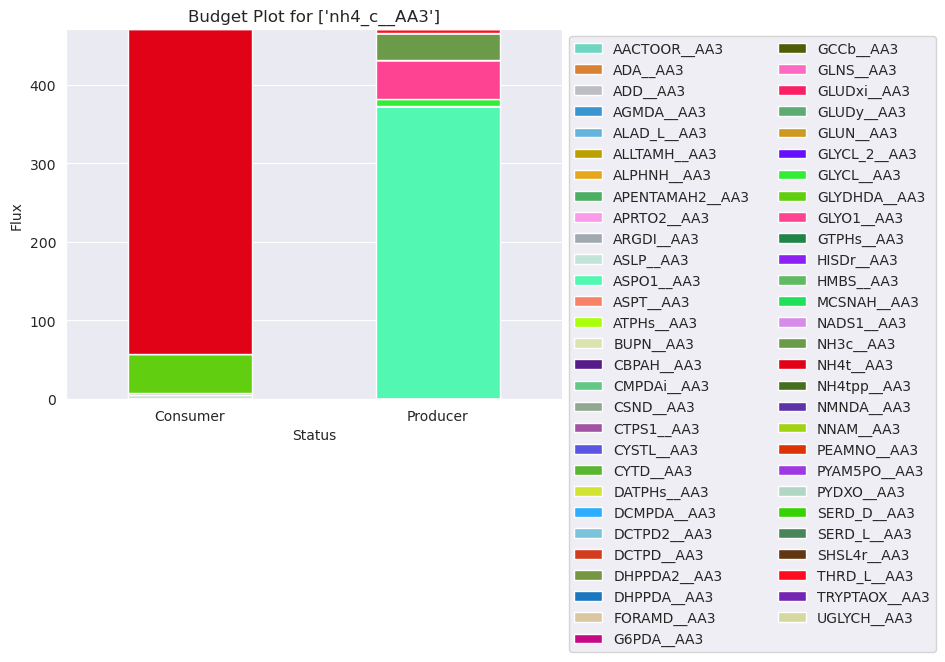

In [13]:
budget_plot_allInOne(S7, "^nh4_c__AA3", medium_combined_krumbach)

In [21]:
AA1.reactions.Growth.metabolites

{<Metabolite 10fthf_c at 0x7b6bc6191270>: -0.000223,
 <Metabolite ala__L_c at 0x7b6bc620afe0>: -0.513689,
 <Metabolite amet_c at 0x7b6bc6208160>: -0.000223,
 <Metabolite arg__L_c at 0x7b6bc6214160>: -0.295792,
 <Metabolite asn__L_c at 0x7b6bc62150f0>: -0.241055,
 <Metabolite asp__L_c at 0x7b6bc62158d0>: -0.241055,
 <Metabolite atp_c at 0x7b6bc6215d50>: -54.124831,
 <Metabolite ca2_c at 0x7b6bc62177c0>: -0.005205,
 <Metabolite cl_c at 0x7b6bc5e216f0>: -0.005205,
 <Metabolite coa_c at 0x7b6bc5e235e0>: -0.000576,
 <Metabolite cobalt2_c at 0x7b6bc5e23f70>: -0.0001,
 <Metabolite ctp_c at 0x7b6bc5e20340>: -0.133508,
 <Metabolite cu2_c at 0x7b6bc5e20160>: -0.000709,
 <Metabolite cys__L_c at 0x7b6bc5e20220>: -0.09158,
 <Metabolite datp_c at 0x7b6bc5e393c0>: -0.026166,
 <Metabolite dctp_c at 0x7b6bc5e3b340>: -0.027017,
 <Metabolite dgtp_c at 0x7b6bc5e38760>: -0.027017,
 <Metabolite dttp_c at 0x7b6bc5e5c160>: -0.026166,
 <Metabolite fad_c at 0x7b6bc5e48eb0>: -0.000223,
 <Metabolite fe2_c at 0x7b

In [20]:
test_medium(S7, medium_combined_krumbach)

model
AA1    15.097689
AA2    15.086133
AA3    15.097689
AA4    15.097689
AA5    15.097689
AA6    15.097689
Name: Growth, dtype: float64

In [35]:
get_rxn(AA6, "PYK2")

PYK2: h_c + pep_c + udp_c --> pyr_c + utp_c


## new Investigation, september

In [133]:
def check_early_biomass_component2(model, medium_dict, check_rxn_id):
    rxn_id = "objective_check"
    sad_mets = []

    check_mets = model.reactions.get_by_id(check_rxn_id).metabolites
    #check_mets = model.reactions.check_rxn_id.metabolites
    for met, flux in check_mets.items():
        if flux < 0: # only look at mets that are consumed
            #print(met)
            stoich = {met: flux}

            if rxn_id in model.reactions: # biomass test reaction is updated
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.subtract_metabolites(rxn.metabolites)
                rxn.add_metabolites(stoich)
            else: # first time reaction is created
                new_rxn = Reaction(id=rxn_id, name="objective reaction", lower_bound=0, upper_bound=1000)
                new_rxn.add_metabolites(stoich)
                model.add_reactions([new_rxn])
                rxn = model.reactions.get_by_id(rxn_id)
                rxn.global_id = rxn_id
                rxn.community_id = "AA"

            model.objective = rxn_id

            with model:
                #change_medium(model, medium_dict)
                try:
                    pfba_flux = convert_cooptradeoff_into_fluxes(model, medium_dict)
                    if pfba_flux[rxn_id] == 0:
                        sad_mets.append(met.id)
                except Infeasible:
                    print("Cannot get result because pfba is infeasible")

    if rxn_id in model.reactions:
        rxn = model.reactions.get_by_id(rxn_id)
        model.remove_reactions([rxn])

    print(sad_mets)

In [13]:
with S7_noS:
    _, growth_val = community_pfba(S7_noS, medium_combined_krumbach)
    print(growth_val)

model
AA1    17.340410
AA2    17.670702
AA3    14.339311
AA4    14.229205
AA5    14.545219
AA6    14.836640
Name: Growth, dtype: float64


In [28]:
with S7_2:
    #S7_2.reactions.EX_sucr_e__AA1.knock_out()
    #S7_2.reactions.EX_sucr_e__AA3.knock_out()
    #S7_2.reactions.EX_sucr_e__AA5.knock_out()
    #S7_2.reactions.EX_sucr_e__AA6.knock_out()
    growth_val= test_medium(S7_2, medium_combined_naveed)
    print(growth_val)

model
AA1    14.290908
AA2    13.122286
AA3     0.000333
AA4    30.134652
AA5    20.607438
AA6    21.577263
Name: Growth, dtype: float64


In [38]:
with S7_2:
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    17.340410
AA2    17.670702
AA3    14.339311
AA4    14.229205
AA5    14.545219
AA6    14.836640
Name: Growth, dtype: float64


In [53]:
with S7_2:
    S7_2.reactions.EX_sucr_e__AA1.knock_out()
    S7_2.reactions.SUCpts__AA1.knock_out()
    S7_2.reactions.SPP__AA1.knock_out()
    S7_2.reactions.SUCR__AA1.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    15.147427
AA2    14.837427
AA3    15.147425
AA4    15.147433
AA5    15.147431
AA6    15.147432
Name: Growth, dtype: float64


In [43]:
with S7_2:
    S7_2.reactions.SPP__AA1.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    15.103301
AA2    15.058334
AA3    15.103301
AA4    15.103302
AA5    15.103302
AA6    15.103302
Name: Growth, dtype: float64


In [40]:
with S7_2:
    S7_2.reactions.SUCpts__AA1.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    17.352360
AA2    17.318521
AA3    14.340575
AA4    14.392069
AA5    14.655848
AA6    14.897899
Name: Growth, dtype: float64


In [47]:
with S7_2:
    S7_2.reactions.SUCR__AA1.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    17.346300
AA2    17.764202
AA3    14.339054
AA4    14.193327
AA5    14.514472
AA6    14.810915
Name: Growth, dtype: float64


In [80]:
with S7_2:
    #S7_2.reactions.EX_sucr_e__AA1.knock_out()
    #S7_2.reactions.EX_sucr_e__AA2.knock_out()
    S7_2.reactions.EX_sucr_e__AA3.knock_out()
    #S7_2.reactions.EX_sucr_e__AA4.knock_out()
    S7_2.reactions.EX_sucr_e__AA5.knock_out()
    S7_2.reactions.EX_sucr_e__AA6.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    17.376744
AA2    17.854709
AA3    14.309582
AA4    14.149390
AA5    14.483334
AA6    14.791797
Name: Growth, dtype: float64


In [71]:
with S7_2:
    S7_2.reactions.EX_sucr_e__AA1.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1    15.107451
AA2    15.037322
AA3    15.107451
AA4    15.107451
AA5    15.107451
AA6    15.107451
Name: Growth, dtype: float64


In [166]:
with S7_2:
    #S7_2.reactions.EX_sucr_e__AA1.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1   17.34040969
AA2   17.67070225
AA3   14.33931140
AA4   14.22920546
AA5   14.54521870
AA6   14.83664034
Name: Growth, dtype: float64


In [164]:
with S7_2:
    S7_2.reactions.SUCpts__AA1.knock_out()
    growth_val= test_medium(S7_2, medium_combined_krumbach)
    print(growth_val)

model
AA1   17.35236011
AA2   17.31852115
AA3   14.34057492
AA4   14.39206902
AA5   14.65584814
AA6   14.89789892
Name: Growth, dtype: float64


[<Metabolite sucr_m at 0x76b41cb7f640>]
Sum of consumer fluxes: 0.00010892978922575868
Sum of producer fluxes: 7.598842528479465e-05


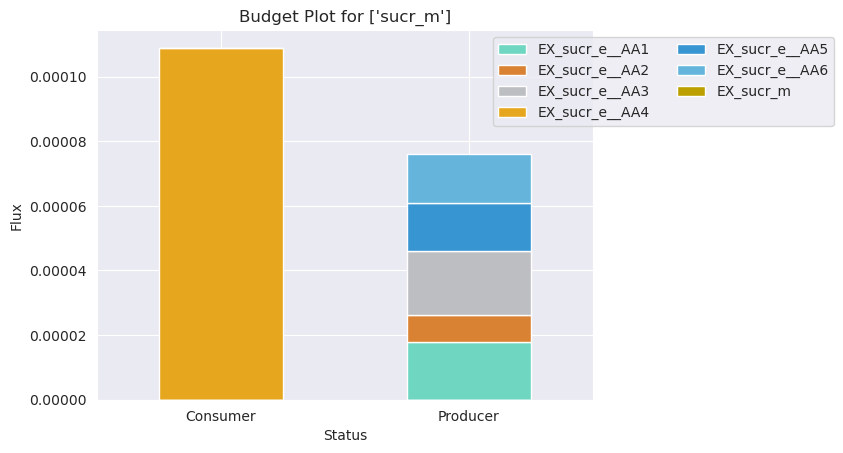

In [75]:
budget_plot_allInOne(S7_2, "^sucr_m", medium_combined_krumbach)

In [82]:
get_met(AA3_noS, "sucr_e")

Sucrose C12H22O11 (C12H22O11)
{'SUCRt2': 'h_e + sucr_e --> h_c + sucr_c', 'EX_sucr_e': 'sucr_e <=> ', 'SUCpts': 'pep_c + sucr_e --> pyr_c + suc6p_c'}


In [91]:
krumbach_com = e_to_m(medium_combined_krumbach)
krumbach_com = {
        rxn: bound for rxn, bound in krumbach_com.items()
        if rxn in S7_2.reactions
    }

In [112]:
with S7_2:
    #S7_2.reactions.EX_sucr_e__AA1.knock_out()
    #S7_2.reactions.EX_sucr_e__AA2.knock_out()
    S7_2.reactions.EX_sucr_e__AA3.knock_out()
    #S7_2.reactions.EX_sucr_e__AA4.knock_out()
    S7_2.reactions.EX_sucr_e__AA5.knock_out()
    S7_2.reactions.EX_sucr_e__AA6.knock_out()
    S7_2.medium = krumbach_com
    basic_fluxes = S7_2.cooperative_tradeoff(fluxes=True, pfba=True).fluxes.transpose()

In [113]:
basic_fluxes

compartment,AA1,AA2,AA3,AA4,AA5,AA6,medium
reaction,,,,,,,
12DGR120tipp,2.890176e-05,3.056440e-05,1.890532e-05,3.005542e-05,0.000031,3.117963e-05,NaN
12DGR140tipp,2.890176e-05,3.056440e-05,1.890331e-05,2.926893e-05,0.000031,3.135865e-05,NaN
12DGR141tipp,2.890176e-05,3.056440e-05,1.890532e-05,3.032465e-05,0.000031,3.132375e-05,NaN
12DGR160tipp,NaN,NaN,1.507596e-05,NaN,0.000030,NaN,NaN
12DGR161tipp,3.357157e-05,3.056440e-05,1.729809e-05,1.064184e+00,1.089331,3.889225e-05,NaN
...,...,...,...,...,...,...,...
sink_amob_c,NaN,1.970790e-06,NaN,3.235318e-06,NaN,NaN,NaN
sink_hemeO_c,3.649124e-07,2.886653e-07,3.265307e-07,3.733293e-07,NaN,2.888843e-07,NaN
sink_lipopb_c,NaN,2.158492e-05,2.022239e-05,2.159351e-05,NaN,NaN,NaN


In [124]:
with S7_2:
    #S7_2.reactions.EX_sucr_e__AA1.knock_out()
    S7_2.reactions.SPP__AA1.knock_out()
    #S7_2.reactions.EX_sucr_e__AA2.knock_out()
    S7_2.reactions.EX_sucr_e__AA3.knock_out()
    #S7_2.reactions.EX_sucr_e__AA4.knock_out()
    S7_2.reactions.EX_sucr_e__AA5.knock_out()
    S7_2.reactions.EX_sucr_e__AA6.knock_out()
    print(test_medium(S7_2, krumbach_com))

com
model
AA1    17.353519
AA2    17.306776
AA3    14.340571
AA4    14.397724
AA5    14.659815
AA6    14.900256
Name: Growth, dtype: float64


[<Metabolite sucr_e__AA1 at 0x7759d0601ea0>]
Sum of consumer fluxes: 4.979993474650919e-05
Sum of producer fluxes: 0.0
                  fluxes    Status           label
EX_sucr_e__AA1  0.000035  Consumer  EX_sucr_e__AA1
SUCpts__AA1     0.000015  Consumer     SUCpts__AA1


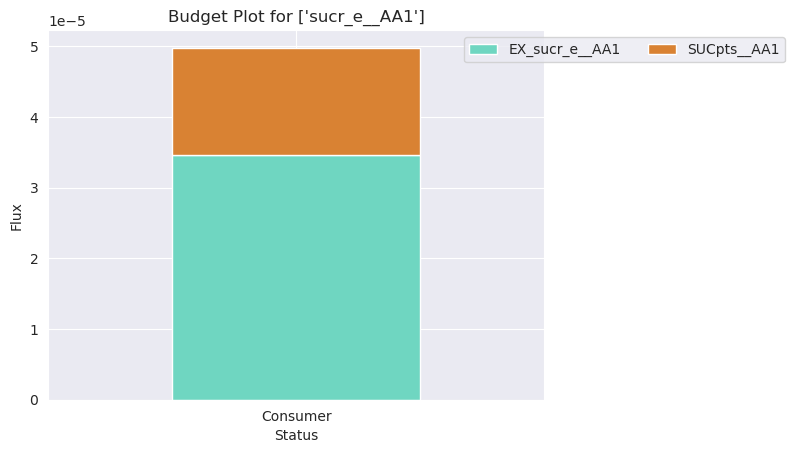

In [81]:
with S7_2:
    #S7_2.reactions.EX_sucr_e__AA1.knock_out()
    #S7_2.reactions.EX_sucr_e__AA2.knock_out()
    S7_2.reactions.EX_sucr_e__AA3.knock_out()
    #S7_2.reactions.EX_sucr_e__AA4.knock_out()
    S7_2.reactions.EX_sucr_e__AA5.knock_out()
    S7_2.reactions.EX_sucr_e__AA6.knock_out()
    budget_plot_allInOne(S7_2, "^sucr_e__AA1", medium_combined_krumbach, print_rxns=True)

[<Metabolite pyr_c__AA1 at 0x7759d0601180>]
Sum of consumer fluxes: 101.64101241815503
Sum of producer fluxes: 101.6410162597261
                      fluxes    Status           label
ACGApts__AA1    1.095711e-07  Producer    ACGApts__AA1
ACGAptspp__AA1  1.086521e-07  Producer  ACGAptspp__AA1
ACMANApts__AA1  1.410575e-07  Producer  ACMANApts__AA1
ADCL__AA1       1.009842e-02  Producer       ADCL__AA1
AGPOP__AA1      3.615774e-05  Producer      AGPOP__AA1
ALATA_D__AA1    2.341798e-01  Producer    ALATA_D__AA1
ALATA_D2__AA1   1.346250e-06  Producer   ALATA_D2__AA1
ALATA_L__AA1    3.811812e+01  Producer    ALATA_L__AA1
ALATA_L2__AA1   1.507903e-06  Producer   ALATA_L2__AA1
ANS__AA1        1.246164e-07  Producer        ANS__AA1
ANS2__AA1       3.714660e-07  Producer       ANS2__AA1
ARBTpts__AA1    1.532768e-07  Producer    ARBTpts__AA1
DAAD__AA1       1.257755e-05  Producer       DAAD__AA1
DDPGALA__AA1    1.198880e-06  Producer    DDPGALA__AA1
DHAPT__AA1      3.698608e-07  Producer      DH

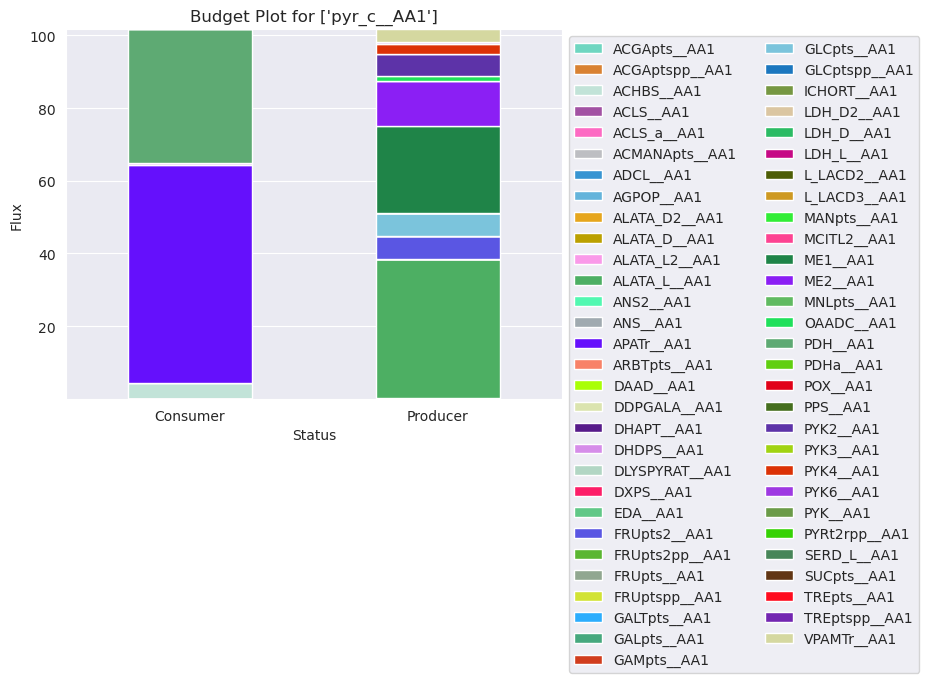

In [125]:
budget_plot_allInOne(S7_2, "^pyr_c__AA1", medium_combined_krumbach, print_rxns=True)

[<Metabolite fru_c__AA1 at 0x76b3e9fd11e0>]
Sum of consumer fluxes: 3.3124718766192334e-09
Sum of producer fluxes: 3.618012366395576e-09
                 fluxes    Status         label
F1PP__AA1    0.00000000  Producer     F1PP__AA1
F6PP__AA1    0.00000000  Producer     F6PP__AA1
FRUt3__AA1   0.00000000  Producer    FRUt3__AA1
SBTD_D2__AA1 0.00000000  Producer  SBTD_D2__AA1
HEX7__AA1    0.00000000  Consumer     HEX7__AA1
FFSD1r__AA1  0.00000000  Consumer   FFSD1r__AA1


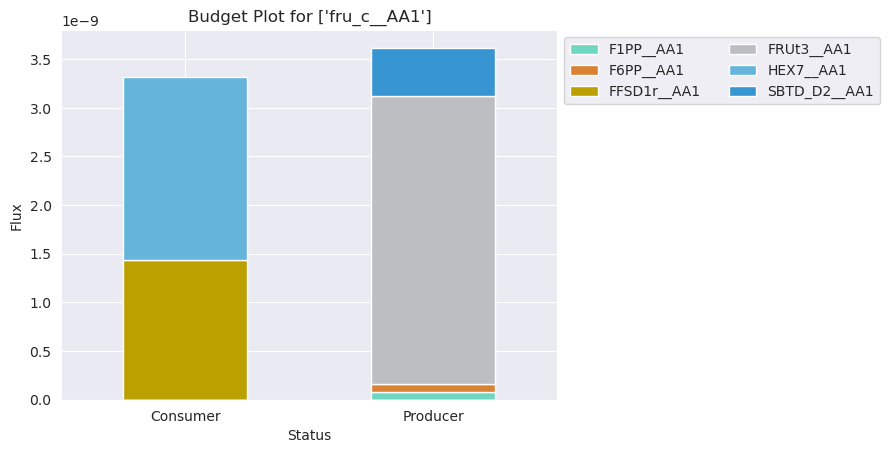

In [155]:
budget_plot_allInOne(S7, "^fru_c__AA1", medium_combined_krumbach, print_rxns=True)

[<Metabolite fru_c__AA3 at 0x76b3deacc1f0>]
Sum of consumer fluxes: 19.4896503656155
Sum of producer fluxes: 19.489650366217294
                  fluxes    Status         label
F1PP__AA3     0.00000000  Producer     F1PP__AA3
F6PP__AA3     0.00000000  Producer     F6PP__AA3
FRUt3__AA3    0.00000000  Producer    FRUt3__AA3
SBTD_D2__AA3  0.00000000  Producer  SBTD_D2__AA3
SUCR__AA3     0.00000000  Producer     SUCR__AA3
XYLI2__AA3   19.48965036  Producer    XYLI2__AA3
HEX7__AA3    19.48965037  Consumer     HEX7__AA3


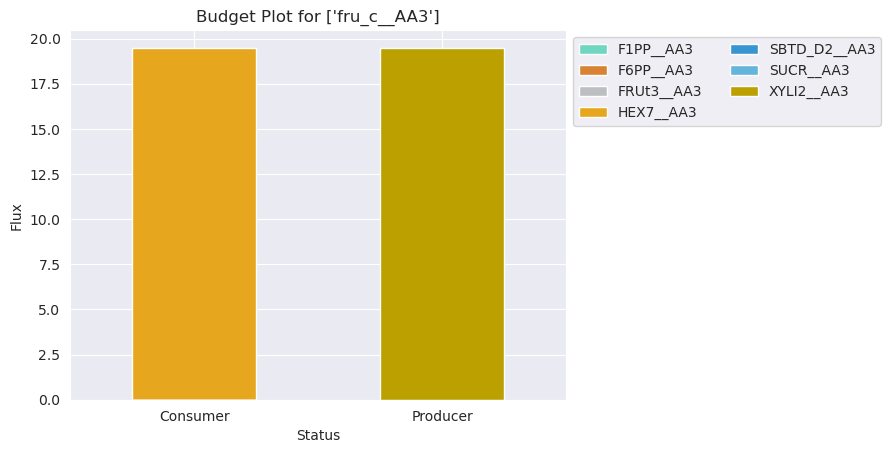

In [142]:
budget_plot_allInOne(S7, "^fru_c__AA3", medium_combined_krumbach, print_rxns=True)

[<Metabolite fru_c__AA3 at 0x76b39d182fb0>]
Sum of consumer fluxes: 17.051294219785976
Sum of producer fluxes: 17.051365514817203


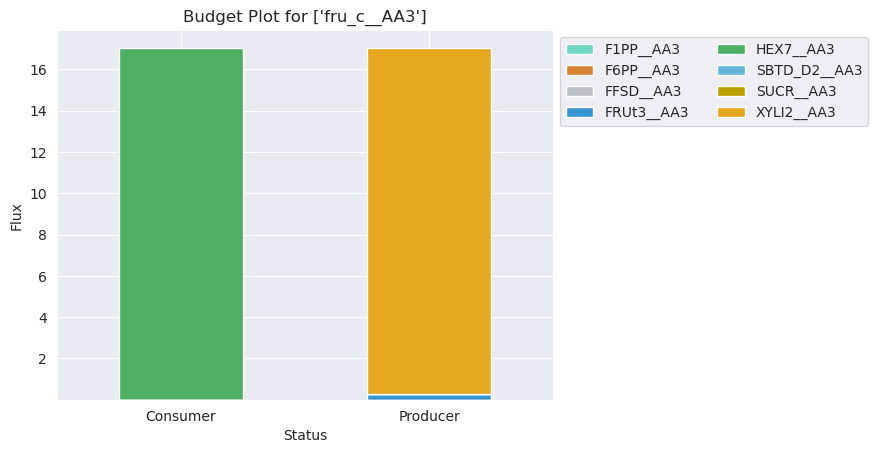

In [138]:
budget_plot_allInOne(S7_2, "^fru_c__AA3", medium_combined_krumbach)

[<Metabolite sucr_c__AA3 at 0x76b41f301810>]
Sum of consumer fluxes: 1.2608375598683634e-05
Sum of producer fluxes: 2.6868413761692376e-05


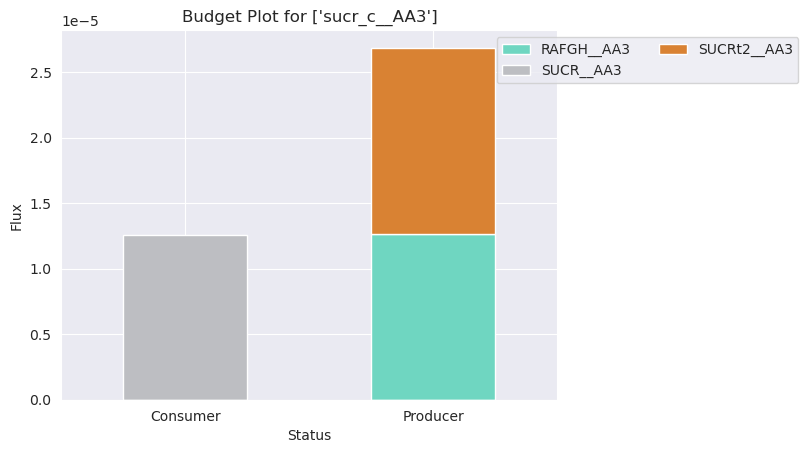

In [83]:
budget_plot_allInOne(S7_2, "^sucr_c__AA3", medium_combined_krumbach)

[<Metabolite sucr_e__AA3 at 0x76b41f301840>]
Sum of consumer fluxes: 4.7457530322298625e-05
Sum of producer fluxes: 0.0


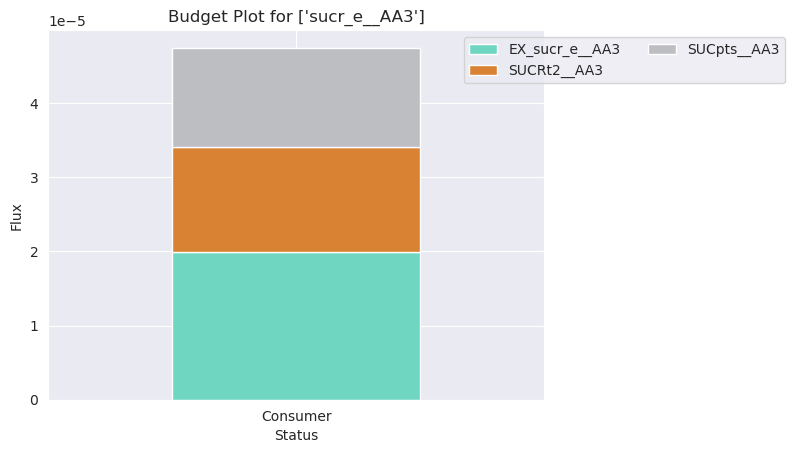

In [79]:
budget_plot_allInOne(S7_2, "^sucr_e__AA3", medium_combined_krumbach)

[<Metabolite sucr_c__AA4 at 0x76b41a7a2890>]
Sum of consumer fluxes: 0.00011390228129838484
Sum of producer fluxes: 0.00012816231946139605


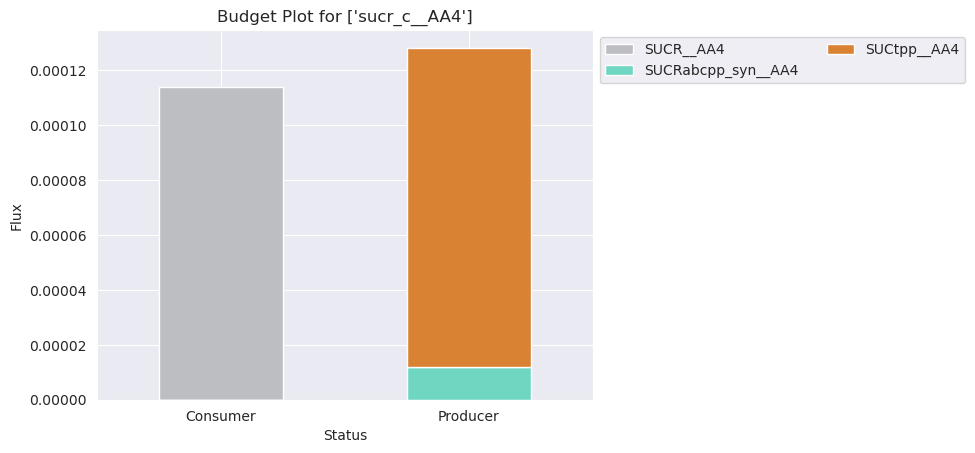

In [61]:
budget_plot_allInOne(S7_2, "^sucr_c__AA4", medium_combined_krumbach)

In [62]:
get_met(S7_2, "sucr_c__AA4")

Sucrose C12H22O11 (C12H22O11)
{'SUCRabcpp_syn__AA4': 'atp_c__AA4 + h2o_c__AA4 + sucr_p__AA4 --> adp_c__AA4 + h_c__AA4 + pi_c__AA4 + sucr_c__AA4', 'SUCtpp__AA4': 'sucr_p__AA4 --> sucr_c__AA4', 'SUCR__AA4': 'h2o_c__AA4 + sucr_c__AA4 --> fru_c__AA4 + glc__D_c__AA4'}


In [58]:
get_met(S7_2, "sucr_p__AA4")

Sucrose C12H22O11 (C12H22O11)
{'SUCRabcpp_syn__AA4': 'atp_c__AA4 + h2o_c__AA4 + sucr_p__AA4 --> adp_c__AA4 + h_c__AA4 + pi_c__AA4 + sucr_c__AA4', 'SUCRtex__AA4': 'sucr_e__AA4 <=> sucr_p__AA4', 'SUCptspp__AA4': 'pep_c__AA4 + sucr_p__AA4 --> pyr_c__AA4 + suc6p_c__AA4', 'SUCtpp__AA4': 'sucr_p__AA4 --> sucr_c__AA4'}


[<Metabolite sucr_p__AA4 at 0x76b41a7a28f0>]
Sum of consumer fluxes: 0.00014764053500213454
Sum of producer fluxes: 8.685449436322194e-05


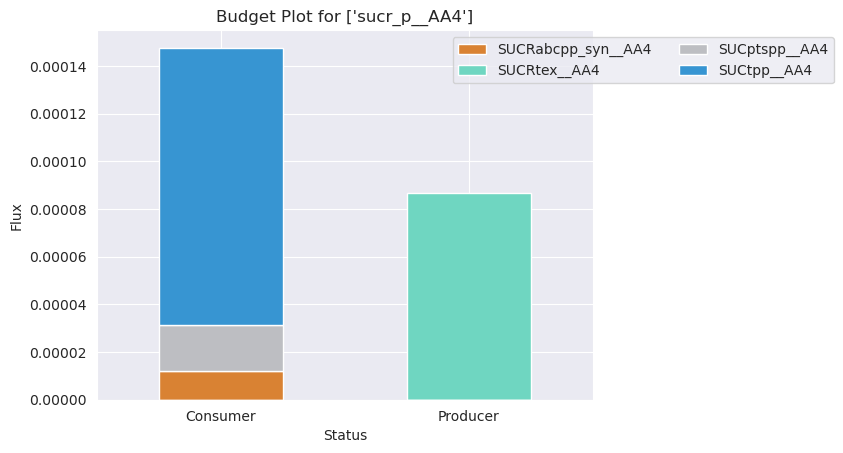

In [59]:
budget_plot_allInOne(S7_2, "^sucr_p__AA4", medium_combined_krumbach)

In [48]:
get_met_unknown(models, "xyl__D_e")

xyl__D_e (D-Xylose (C5H10O5, 0)) is found  models: ['AA1', 'AA2', 'AA3', 'AA4', 'AA5', 'AA6'] and in reactions: {'XYLabc', 'XYLt2', 'XYLt', 'EX_xyl__D_e', 'XYLtex'}
